# HOWTO's and reusable python snippets

### Basic preamble

In [1]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1, 12 + 1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']

colors = prop_cycle.by_key()['color']

## Convert notebook to pdf

`jupyter nbconvert --to pdf file_name.ipynb`

### Including images in markdown and specifing the size
<div>
<img src="TGMM_Blind_Elephant.png" width="200"/>
</div>

Or just quick inline

![Alt text](RISE_slideshow_icon.png)

Or side by side

<table>
<tr>
    <td> <img src="iconic_ENSO_elNino_lrg.jpg" alt="El Nino" style="width: 300px;"/> </td>
    <td> <img src="iconic_ENSO_laNina_lrg.jpg" alt="La Nina" style="width: 300px;"/> </td>
</tr>
</table>    

### Subplots with size and axis sharing

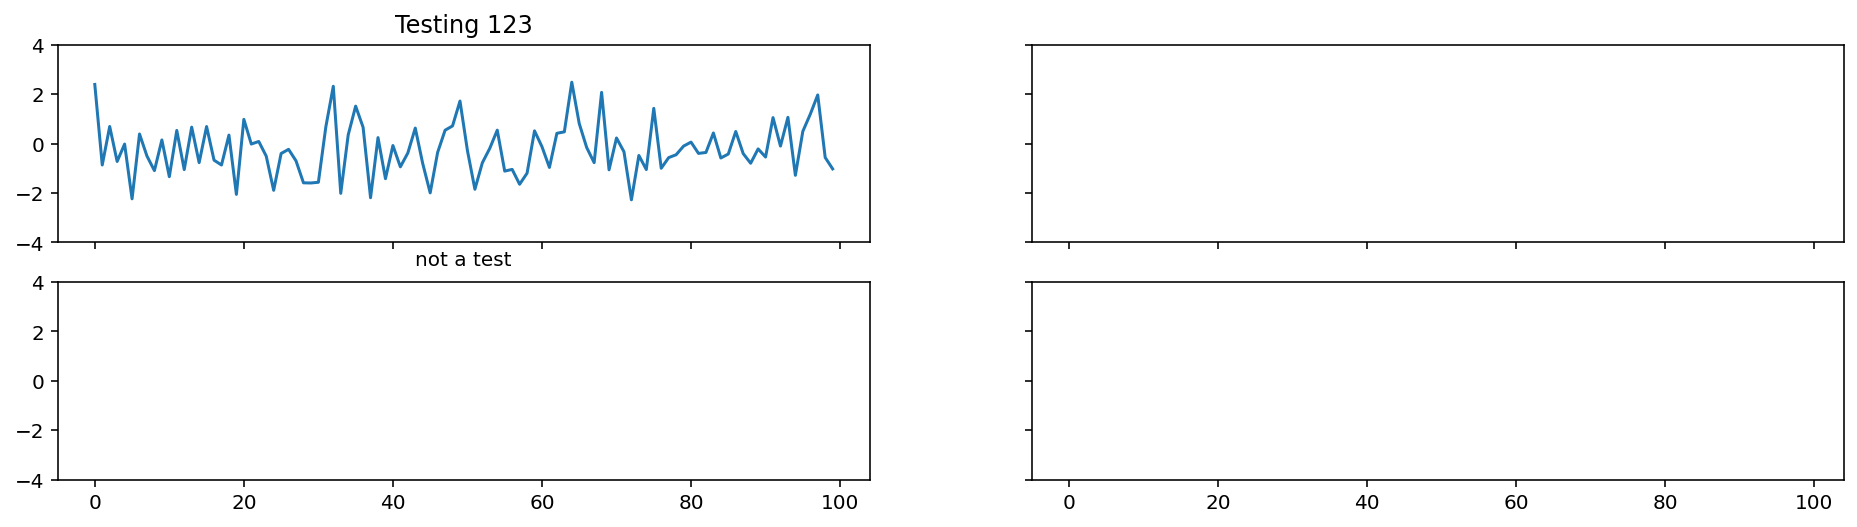

In [111]:
fig, axs = plt.subplots(2, 2, figsize =(16, 4), sharey = True, sharex = True)
axs[0,0].plot(np.random.normal(size = 100));
axs[0,0].set_title('Testing 123');
axs[0,0].set_ylim([-4, 4]);
axs[0,0].set_xlabel('not a test');

### Functions

In [3]:
def cor(x,y):
    xa = x - np.nanmean(x)
    ya = y - np.nanmean(y)
    return np.nansum(xa*ya)/np.sqrt(np.nansum(xa**2)*np.nansum(ya**2))

### Read Nino 3.4 from the data library and compute anomaly wrt 1982-2010 (`xarray`)
Time may or may not work depending on your version of `netcdflib`

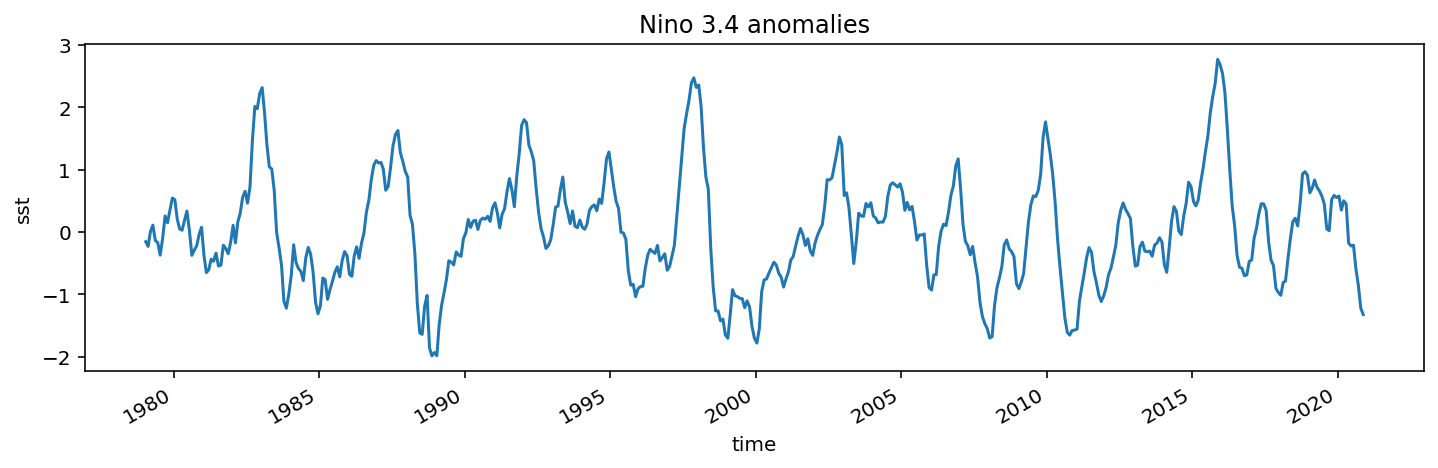

In [143]:
import xarray as xr

t_fix = 'T/(days)/32/string/(since)/32/string/(1960-01-01)/5/array/astore/concat/streamgridunitconvert/'
nino34_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/zlev/removeGRID/T/%28Jan%201979%29/last/RANGE/T/(days%20since%201960-01-01)streamgridunitconvert/dods'

n34_ds = xr.open_dataset(nino34_url)
n34c = n34_ds.sst.sel(T = slice('1982-01-01', '2010-12-31')).groupby('T.month').mean('T')

n34a = n34_ds.sst.groupby('T.month') - n34c
fig, ax = plt.subplots(figsize = (12, 3))
n34a.plot()
ax.set_title('Nino 3.4 anomalies');

### DJF average

In [145]:
n34a_3mon_ave = n34a.rolling(T = 3, center = True, min_periods = 2).mean()
DJF_index = n34a_3mon_ave.groupby('T.month').groups[1]
n34a_DJF = n34a_3mon_ave.isel(T = DJF_index)
n34a_DJF

<xarray.DataArray (T: 42)>
array([-0.19226726,  0.42254247, -0.31862411, -0.078044  ,  2.14893491,
       -0.63008493, -1.07478468, -0.58809529,  1.12185716,  0.70575206,
       -1.79719293,  0.02981618,  0.3869978 ,  1.75244249,  0.13432213,
        0.10406092,  1.00050782, -0.88343355, -0.51474856,  2.22749899,
       -1.56029827, -1.67638868, -0.75617885, -0.1980077 ,  0.87056714,
        0.31664176,  0.58663132, -0.83471591,  0.65869033, -1.6397115 ,
       -0.84426823,  1.49910749, -1.41130055, -0.8641435 , -0.43482007,
       -0.44282037,  0.54646464,  2.48302706, -0.3393143 , -0.93017915,
        0.74613558,  0.49301245])
Coordinates:
  * T        (T) datetime64[ns] 1979-01-16T12:00:00 ... 2020-01-16T12:00:00
    month    (T) int64 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ... 1 1 1 1 1 1 1 1 1 1 1 1 1

### Read ONI from CPC (`pandas`)

In [114]:
import pandas as pd

oni_url = "https://www.cpc.ncep.noaa.gov/data/indices/oni.ascii.txt"
oni_df = pd.read_fwf(oni_url)
oni_df.head()

SEAS    YR  TOTAL  ANOM
0  DJF  1950  24.72 -1.53
1  JFM  1950  25.17 -1.34
2  FMA  1950  25.75 -1.16
3  MAM  1950  26.12 -1.18
4  AMJ  1950  26.32 -1.07

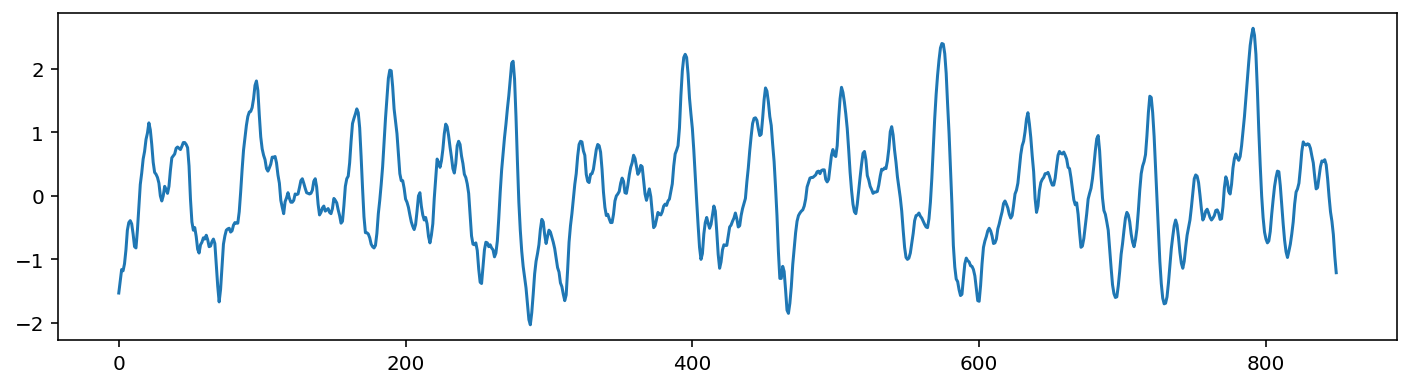

In [115]:
# plot anomalies, w/o time coordinate
oni_df['ANOM'].plot(figsize = (12, 3));

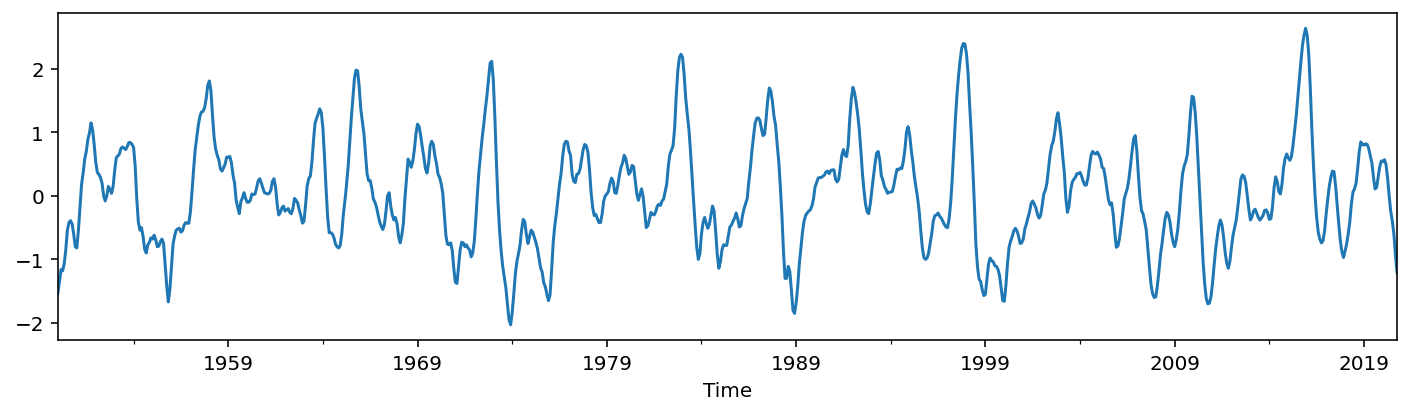

In [116]:
# add a time coordinate to the data frame
n_months = len(oni_df) 
oni_df['Time'] = pd.to_datetime(pd.date_range('1950-01-01', periods = n_months, freq = 'M'))
oni_df.set_index('Time', inplace = True)
oni_df['ANOM'].plot(figsize = (12, 3));

## Maps with coastlines centered on the Pacific and hatching (`xarray` + `cartopy`)

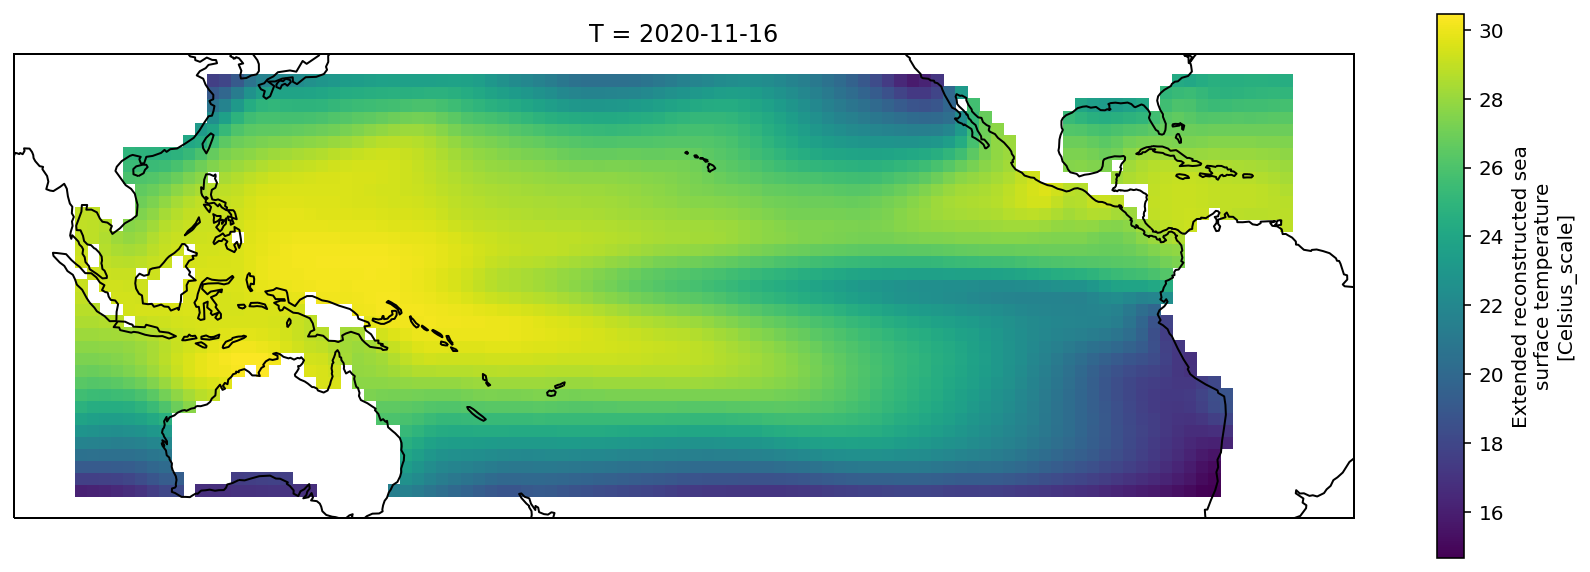

In [117]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ersst5_url="http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-35/35/RANGEEDGES/X/100/300/RANGEEDGES/zlev/removeGRID/T/last/VALUE/T/(days%20since%201960-01-01)streamgridunitconvert/dods"
ersst5_ds = xr.open_dataset(ersst5_url)
sst = ersst5_ds.sst.isel(T = 0)

proj_map = ccrs.PlateCarree(central_longitude = 180)
proj_dta = ccrs.PlateCarree()

fig = plt.figure(figsize = (15, 5))
ax = plt.subplot(projection = proj_map)

sst.plot(ax = ax, transform = proj_dta)
ax.coastlines();

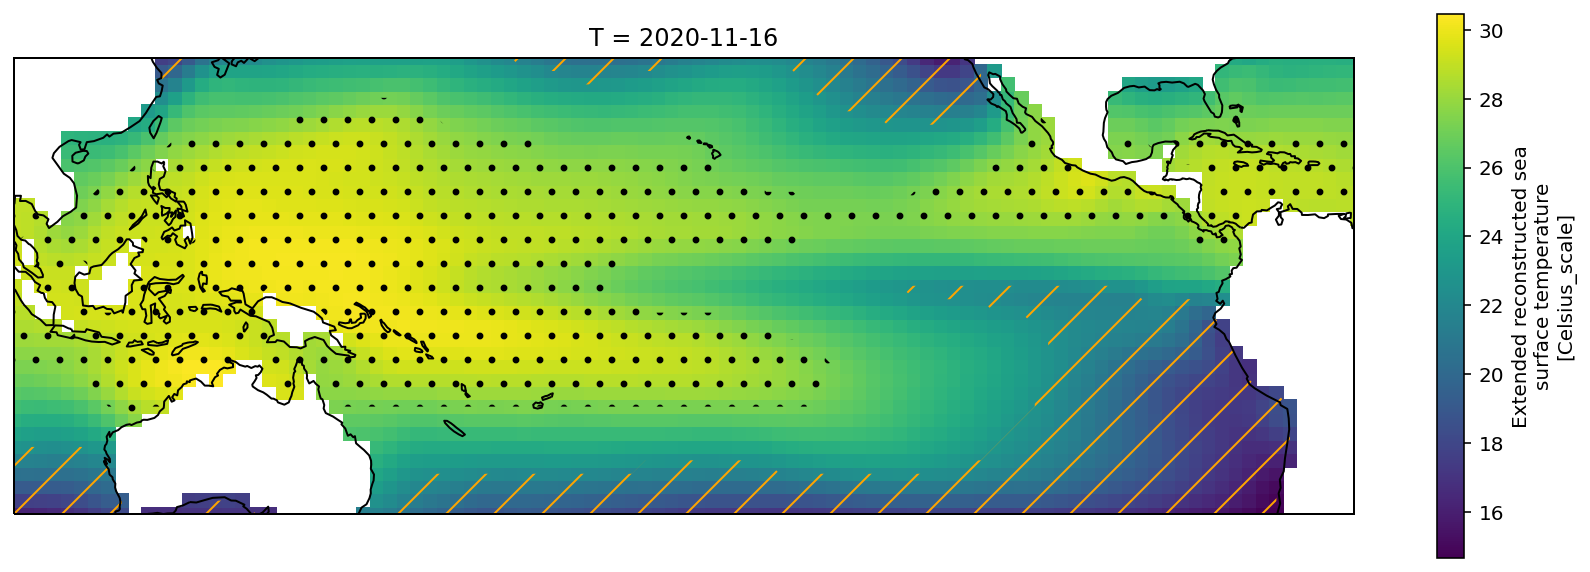

In [118]:
# same as above with hatching
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ersst5_url="http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-35/35/RANGEEDGES/X/100/300/RANGEEDGES/zlev/removeGRID/T/last/VALUE/T/(days%20since%201960-01-01)streamgridunitconvert/dods"
ersst5_ds = xr.open_dataset(ersst5_url)
sst = ersst5_ds.sst.isel(T = 0)

proj_map = ccrs.PlateCarree(central_longitude = 180)
proj_dta = ccrs.PlateCarree()

fig = plt.figure(figsize = (15, 5))
ax = plt.subplot(projection = proj_map)

sst.plot(ax = ax, transform = proj_dta)
ax.coastlines();

#warm
warm = np.zeros(sst.shape) ; 
warm[(np.abs(sst) < 27) | np.isnan(sst)] = np.nan

#cold
cold = np.zeros(sst.shape) ; 
cold[(np.abs(sst) > 23) | np.isnan(sst)] = np.nan

ax.contourf(sst.X, sst.Y, warm, hatches = ['.'], colors = 'none', transform = proj_dta);
cs = ax.contourf(sst.X, sst.Y, cold, hatches = ['/'], colors = 'none', transform = proj_dta);

cs.collections[0].set_edgecolor('orange')
cs.collections[0].set_linewidth(0.)

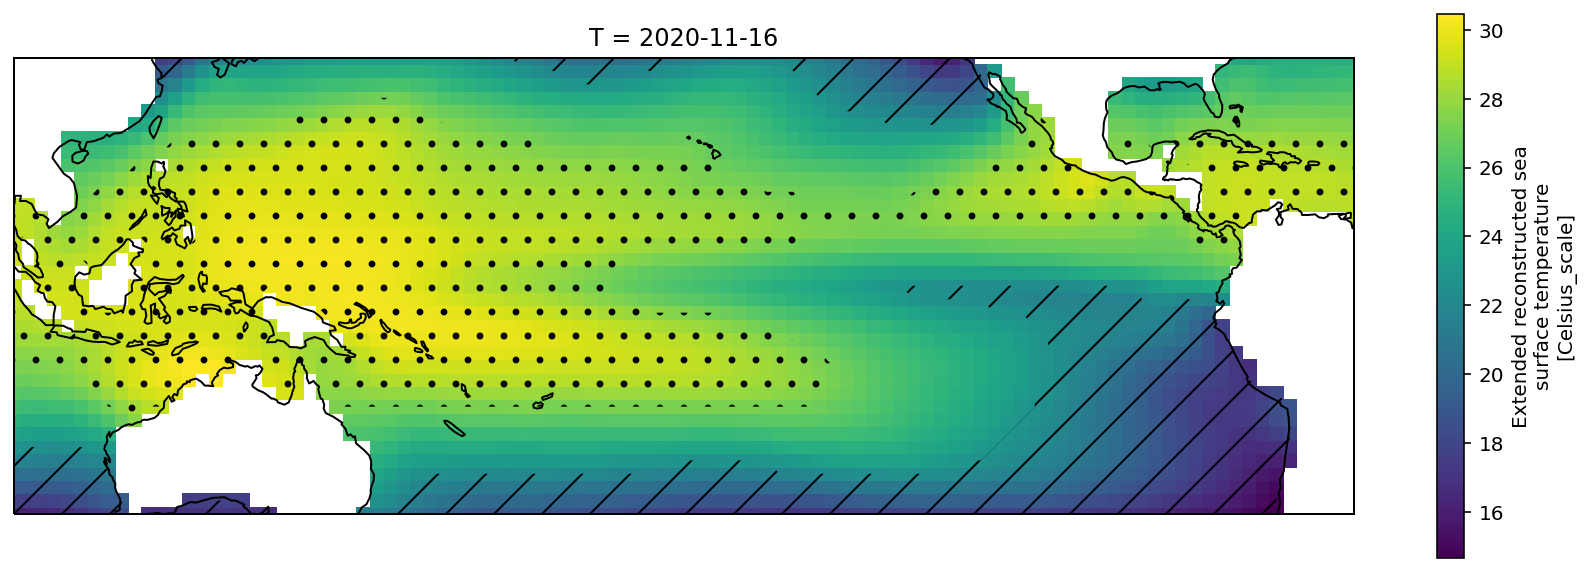

In [119]:
# same as above with xarray instead of numpy arrays
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature

ersst5_url="http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-35/35/RANGEEDGES/X/100/300/RANGEEDGES/zlev/removeGRID/T/last/VALUE/T/(days%20since%201960-01-01)streamgridunitconvert/dods"
ersst5_ds = xr.open_dataset(ersst5_url)
sst = ersst5_ds.sst.isel(T = 0)

proj_map = ccrs.PlateCarree(central_longitude = 180)
proj_dta = ccrs.PlateCarree()

fig = plt.figure(figsize = (15, 5))
ax = plt.subplot(projection = proj_map)

sst.plot(ax = ax, transform = proj_dta)
ax.coastlines();

#warm
warm = sst.copy(data = np.zeros(sst.shape))
warm = warm.where(sst > 27, np.nan)

#cold
cold = sst.copy(data = np.zeros(sst.shape))
cold = cold.where(sst < 23, np.nan)

warm.plot.contourf(hatches = ['.'], colors = 'none', add_colorbar = False, transform = proj_dta);
cs = cold.plot.contourf(hatches = ['/'], colors = 'none', add_colorbar = False, transform = proj_dta);

#Color???

### Read CONUS elevation from the data libaray and plot it on a map

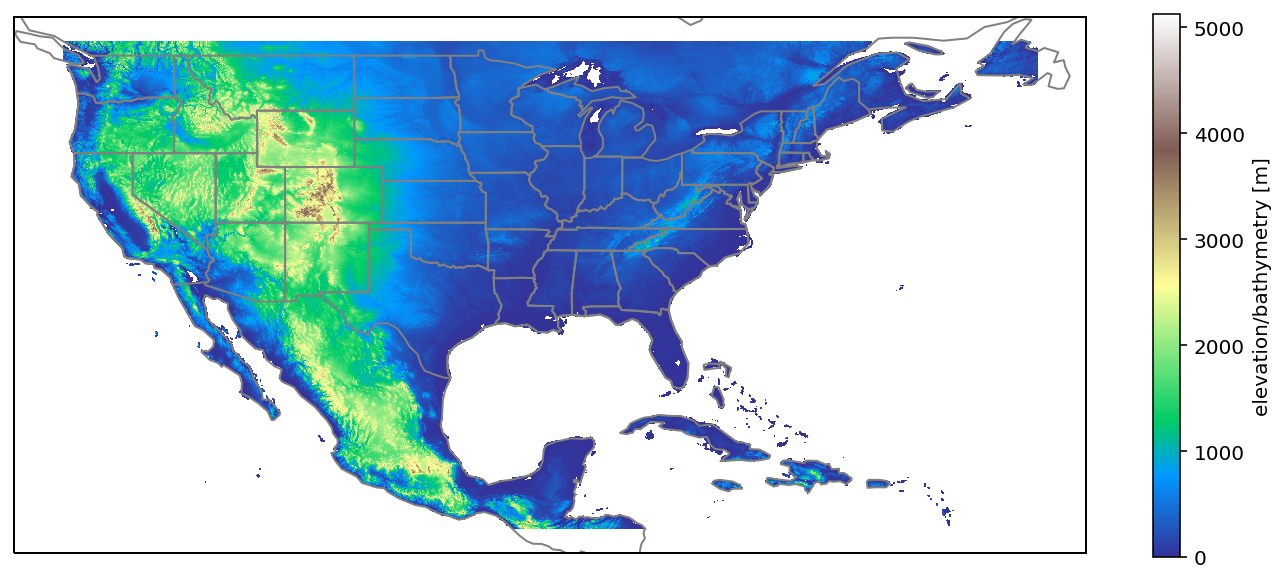

In [122]:
bath_ds = xr.open_dataset('https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NGDC/.ETOPO2v2/.z/X/-125./-55/RANGEEDGES/Y/15/50/RANGEEDGES/0/masklt/dods')

proj = ccrs.PlateCarree()
fig = plt.figure(figsize = (12, 5))
ax = plt.subplot(projection = proj)

elevation = bath_ds.z

elevation.plot(ax = ax, cmap = 'terrain', transform = proj)
ax.add_feature(cfeature.STATES, edgecolor = 'gray')
ax.coastlines(color = 'gray');

### Read GFSv12 SWE and plot it with a wacky colormap

In [97]:
swe_ds = xr.open_dataset('http://iridl.ldeo.columbia.edu/SOURCES/.Models/.SubX/.EMC/.GEFSv12/.forecast/swe/[M]/average/[L]/sum/S/last/VALUE/dods')
swe_ds

<xarray.Dataset>
Dimensions:  (S: 1, X: 360, Y: 181)
Coordinates:
  * X        (X) float32 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * Y        (Y) float32 90.0 89.0 88.0 87.0 86.0 ... -87.0 -88.0 -89.0 -90.0
  * S        (S) datetime64[ns] 2020-12-16
Data variables:
    swe      (S, Y, X) float64 ...
Attributes:
    Conventions:  IRIDL

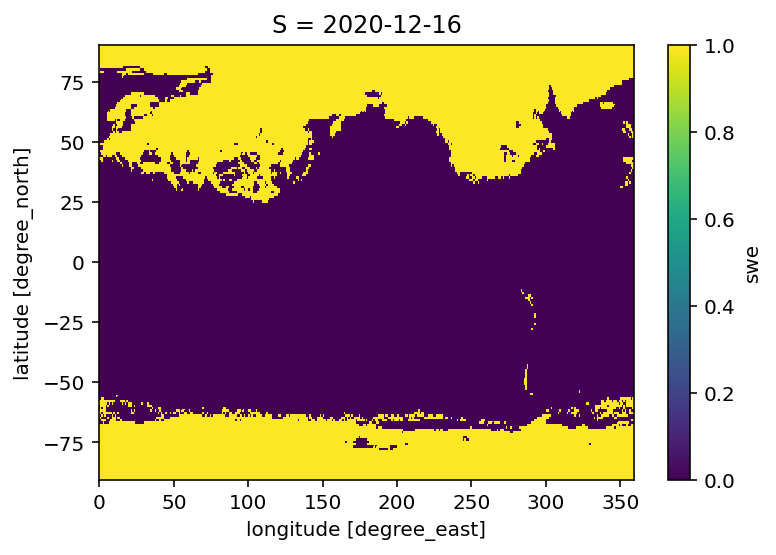

In [108]:
(swe > 10).plot();

In [109]:
import matplotlib.colors as mcolors

nws_precip_colors = [
    "#fdfdfd",  # 0.01 - 0.10 inches
    "#019ff4",  # 0.10 - 0.25 inches
    "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
    "#f800fd",  # 6.00 - 8.00 inches
    "#9854c6"  # 8.00 - 10.00 inches
]
import matplotlib as mp
cmap = mp.colors.ListedColormap(nws_precip_colors)

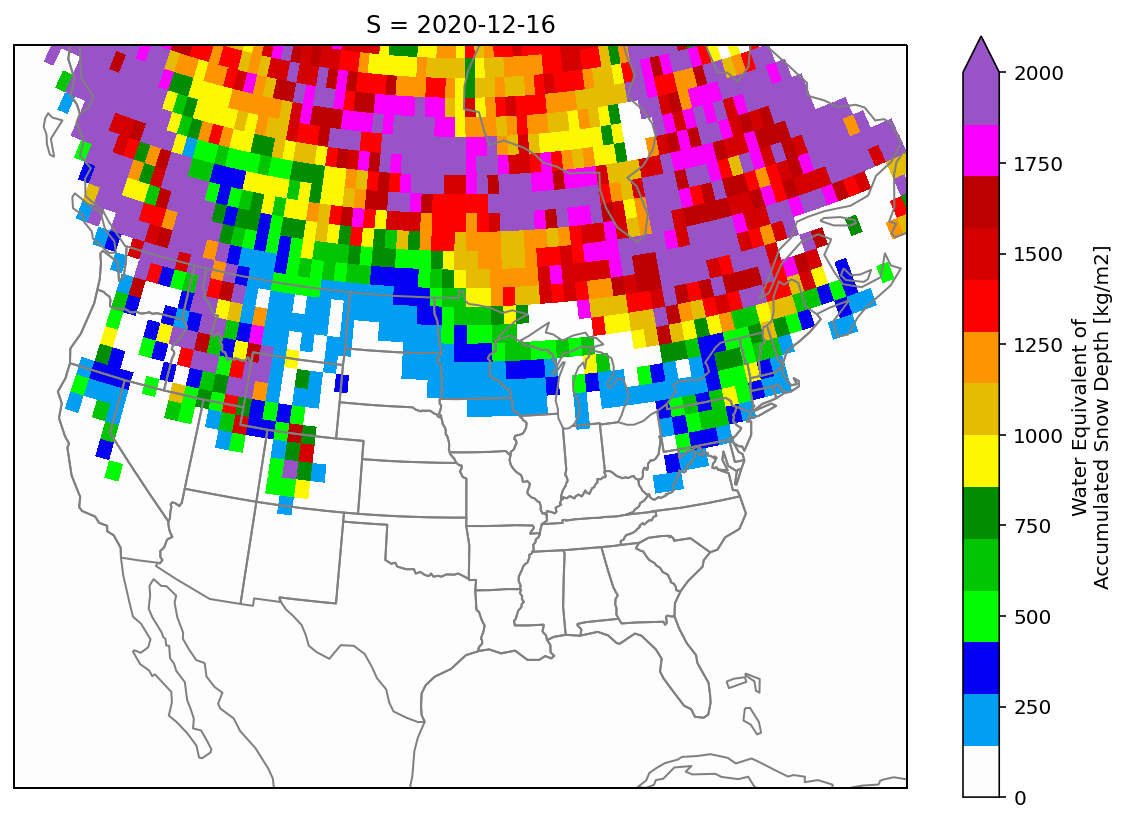

In [123]:
proj_map = ccrs.LambertConformal(central_longitude = -95, central_latitude = 45)
proj_dta = ccrs.PlateCarree()  # the data's projection

fig = plt.figure(figsize = (10, 7))
ax = plt.subplot(projection = proj_map)
extent = [-120, -70, 20, 60.5]

swe.isel(S = 0).plot(transform = proj_dta, ax = ax, cmap = cmap, vmax = 2000)
ax.coastlines(color='gray');
ax.add_feature(cfeature.STATES, edgecolor = 'gray')
ax.set_extent(extent)

### Background NOT tranparent

`fig.set_facecolor("white")`

### `xarray` faceted plots

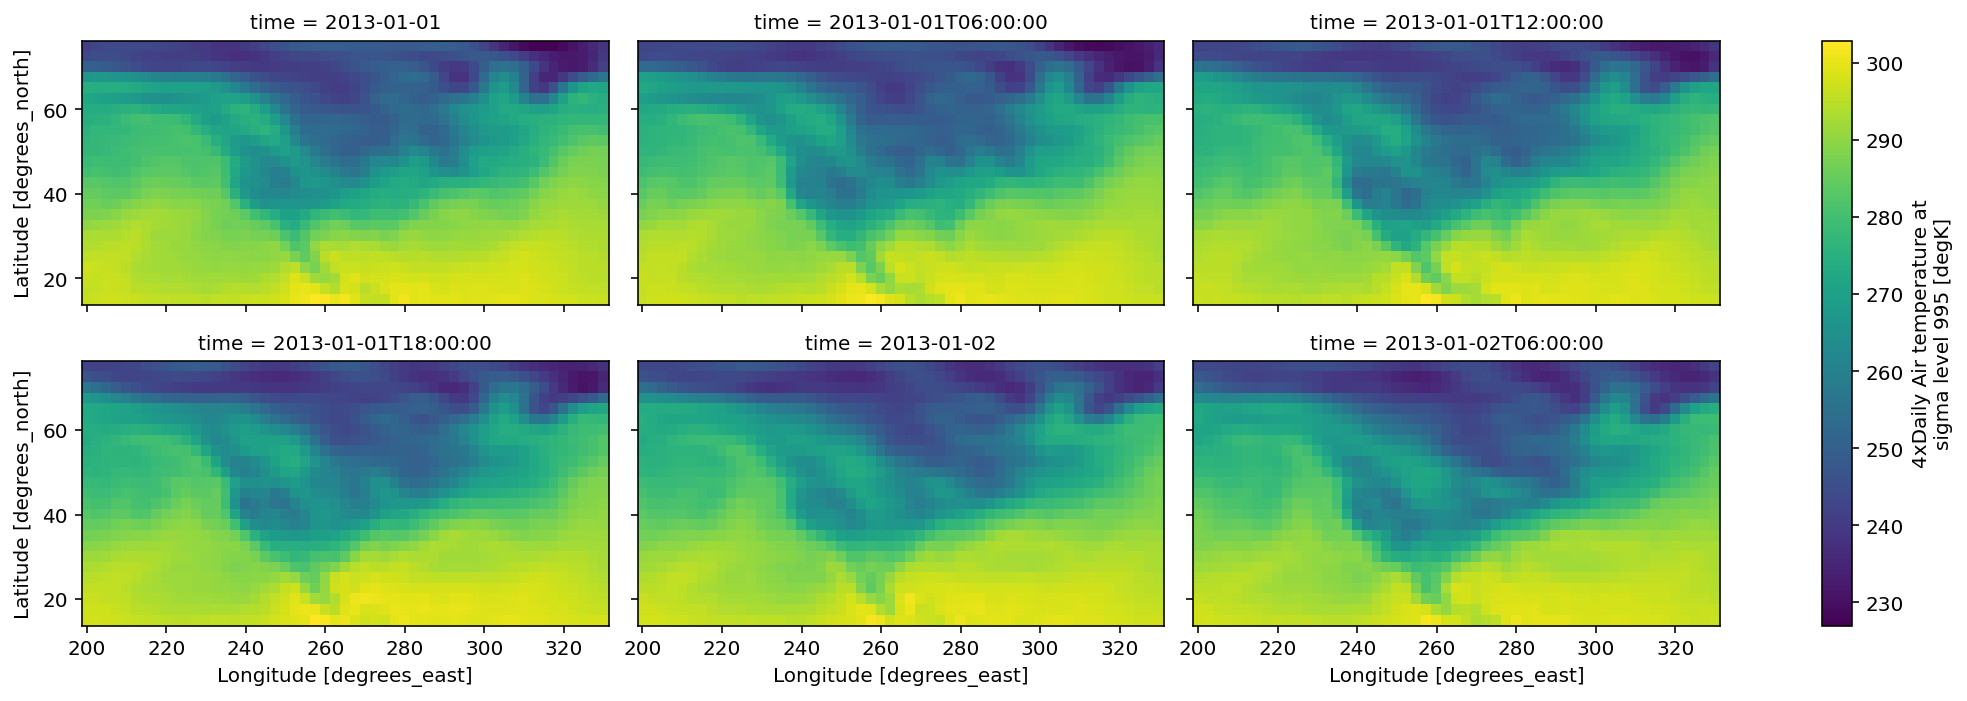

In [124]:
ds = xr.tutorial.open_dataset("air_temperature")
da = ds.air.isel(time = slice(None, 6))
# bare bones, no projection but ticks
da.plot(col = 'time', col_wrap = 3, figsize = (15, 5));

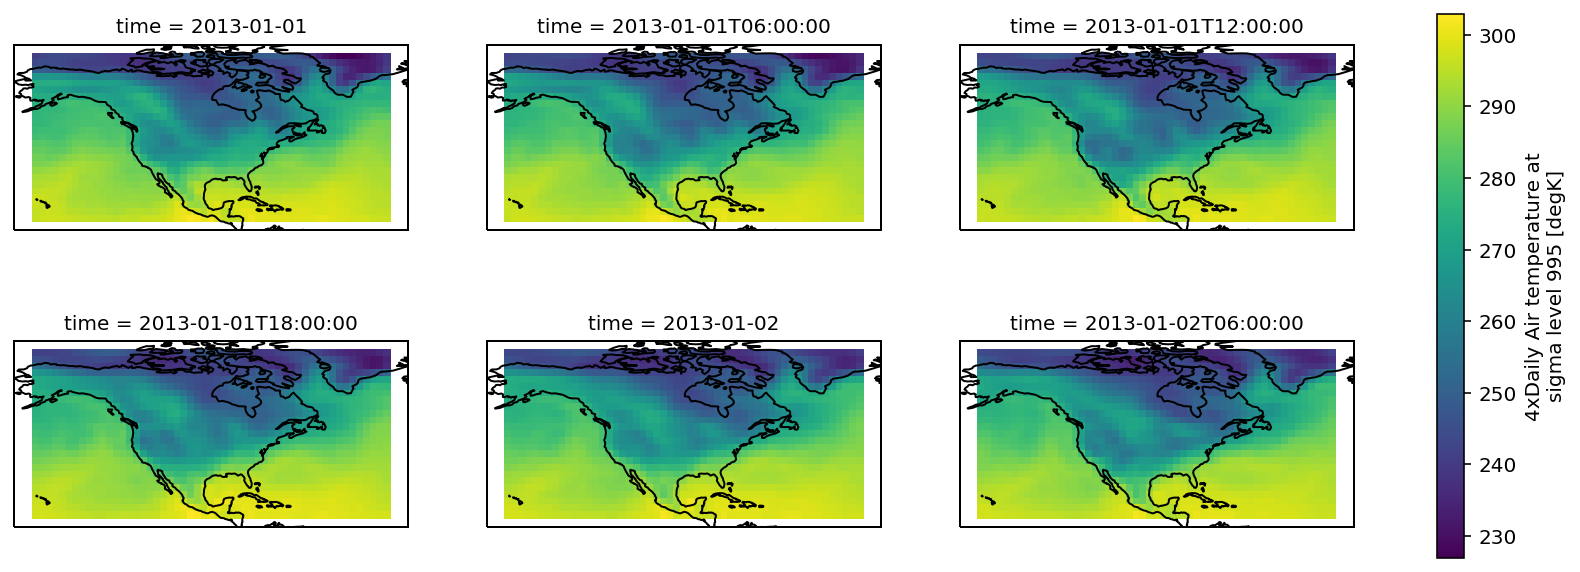

In [126]:
# bare bones with projection, coastlines, no ticks
proj = ccrs.PlateCarree()
g = da.plot(transform=proj, col = 'time', col_wrap = 3, figsize=(15, 5), subplot_kws = {'projection': proj});
for ii, ax in enumerate(g.axes.flat):
    ax.coastlines()

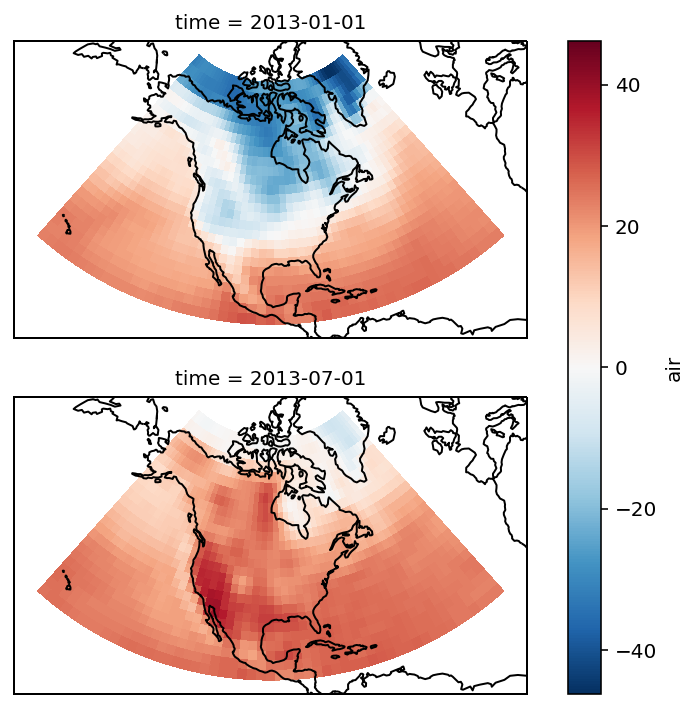

In [141]:
air = ds.air.isel(time=[0, 724]) - 273.15

# This is the map projection we want to plot *onto*
proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection
p = air.plot(transform = proj_dta,  # the data's projection
             col='time', col_wrap= 1,  # multiplot settings
             #figsize=(8, 8),
             aspect=ds.dims['lon'] / ds.dims['lat'],  # for a sensible figsize
             subplot_kws={'projection': proj_map})  # the plot's projection
for ii, ax in enumerate(p.axes.flat):
    ax.coastlines()

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1390: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)
/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  self.fig.tight_layout()


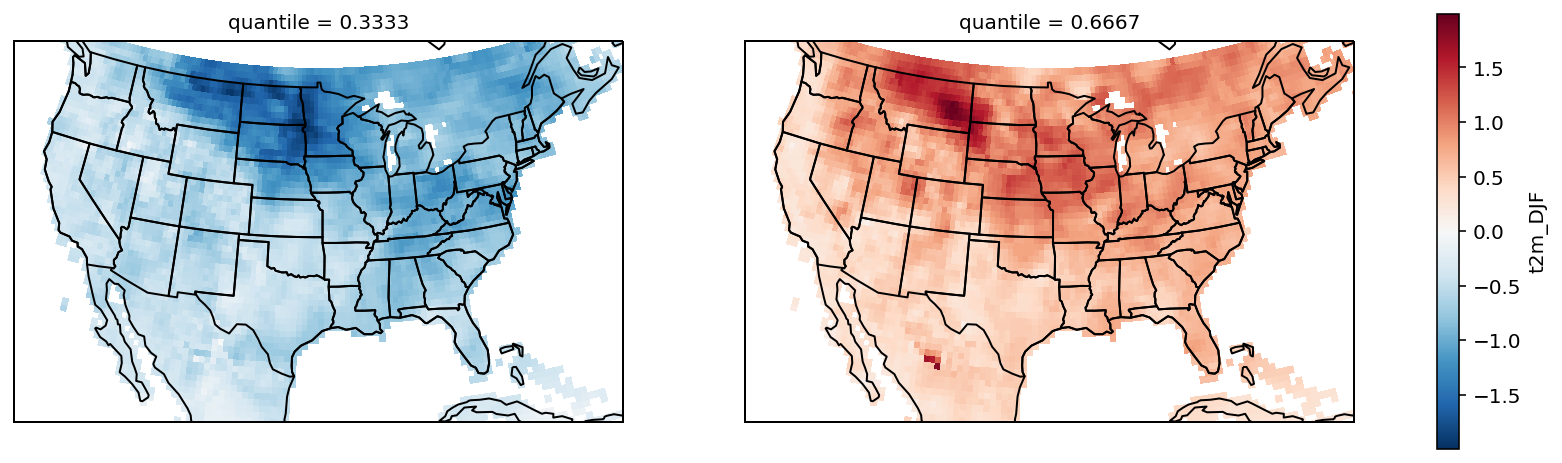

In [571]:
# 2-meter temperature
t2m_DJF_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.t2m_DJF/dods'
t2m_DJF_ds = xr.open_dataset(t2m_DJF_url)

t2m = t2m_DJF_ds.t2m_DJF - t2m_DJF_ds.t2m_DJF.mean('T')
t2m_terciles = t2m.quantile([1./3., 2./3.], dim='T')

proj_map = ccrs.LambertConformal(central_longitude=-95, central_latitude=45)
proj_dta = ccrs.PlateCarree()  # the data's projection

extent = [-120, -70, 20, 50.5]

g = t2m_terciles.plot(x = 'X', y = 'Y', col = 'quantile', figsize=(15,4), 
                      transform = proj_dta, subplot_kws={'projection':proj_map})
for ii, ax in enumerate(g.axes.flat):
    ax.add_feature(cfeature.STATES)
    ax.coastlines()
    ax.set_extent(extent)

### Making pcolor plots line up with coasts

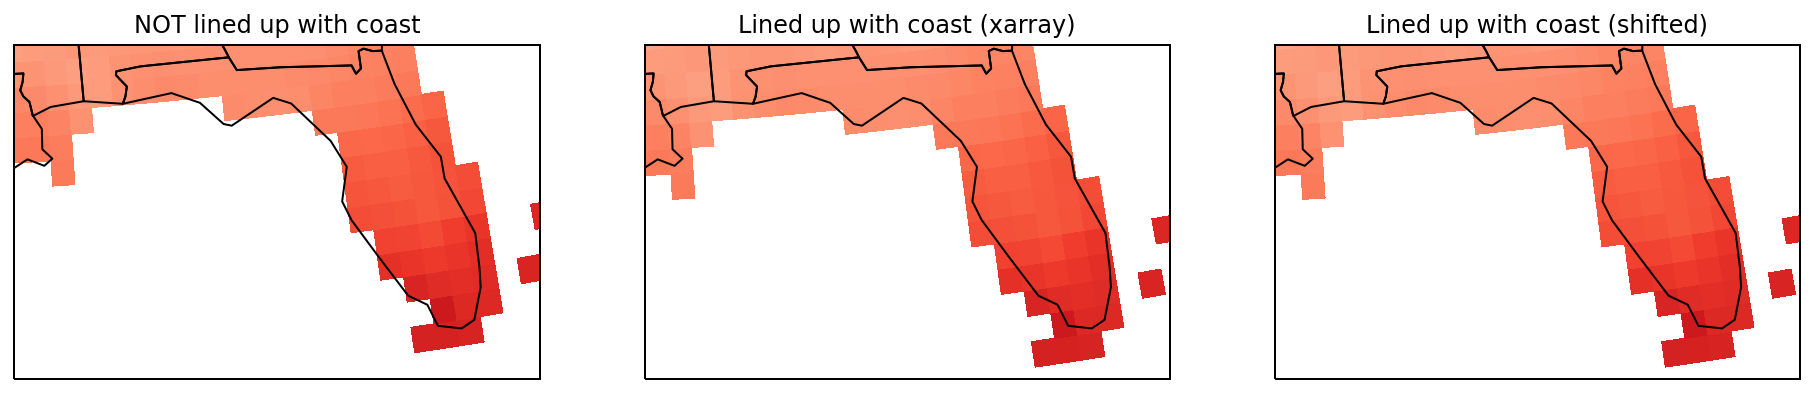

In [165]:
t2m_DJF_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.t2m_DJF/dods'
t2m_DJF_ds = xr.open_dataset(t2m_DJF_url)
t2m = t2m_DJF_ds.t2m_DJF

proj_map = ccrs.LambertConformal(central_longitude = -95, central_latitude = 45)
proj_dta = ccrs.PlateCarree()  # the data's projection
extent = [-90, -79, 25, 30.5]

fig = plt.figure(figsize = (16, 8))

ax = plt.subplot(1, 3, 1, projection = proj_map)
ax.set_title('NOT lined up with coast')
ax.pcolormesh(t2m.X, t2m.Y, t2m[0], cmap = 'Reds', vmin = 0, transform = proj_dta)
ax.add_feature(cfeature.STATES)
ax.set_extent(extent)

ax = plt.subplot(1, 3, 2, projection = proj_map)
t2m[0].plot(ax = ax, transform = proj_dta, cmap = 'Reds', vmin = 0, add_colorbar = False)
ax.set_title('Lined up with coast (xarray)')
ax.add_feature(cfeature.STATES)
ax.set_extent(extent)

ax = plt.subplot(1, 3, 3, projection = proj_map)
ax.set_title('Lined up with coast (shifted)')
#ax.pcolormesh(t2m.X, t2m.Y, t2m[0], cmap = 'Reds', vmin = 0, transform = proj_dta)
ax.pcolormesh(t2m.X - 0.25, t2m.Y - 0.25, t2m[0], cmap = 'Reds', vmin = 0, transform = proj_dta)
ax.add_feature(cfeature.STATES)
ax.set_extent(extent)

In [634]:
t2m

<xarray.DataArray 't2m_DJF' (T: 41, Y: 62, X: 152)>
[386384 values with dtype=float32]
Coordinates:
  * X        (X) float32 -130.25 -129.75 -129.25 ... -55.75 -55.25 -54.75
  * Y        (Y) float32 19.75 20.25 20.75 21.25 ... 48.75 49.25 49.75 50.25
  * T        (T) datetime64[ns] 1980-01-15 1981-01-14T12:00:00 ... 2020-01-15
Attributes:
    gribfield:           1
    standard_name:       air_temperature
    long_name:           Air Temperature
    expires:             1606780800
    file_missing_value:  9.999e+20
    history:             Averaged in T with overlapping interval 3\nBoxes wit...
    units:               Celsius_scale

In [21]:
XY_str = 'X/240/310/RANGE/Y/-30/30/RANGE/'
sst_climo_url = 'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/(Jan%201981)/(Dec%202010)/RANGE/yearly-climatology/' + XY_str + 'zlev/removeGRID/T/(days%20since%201960-01-01)streamgridunitconvert/dods'
sst_climo_ds = xr.open_dataset(sst_climo_url)

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()


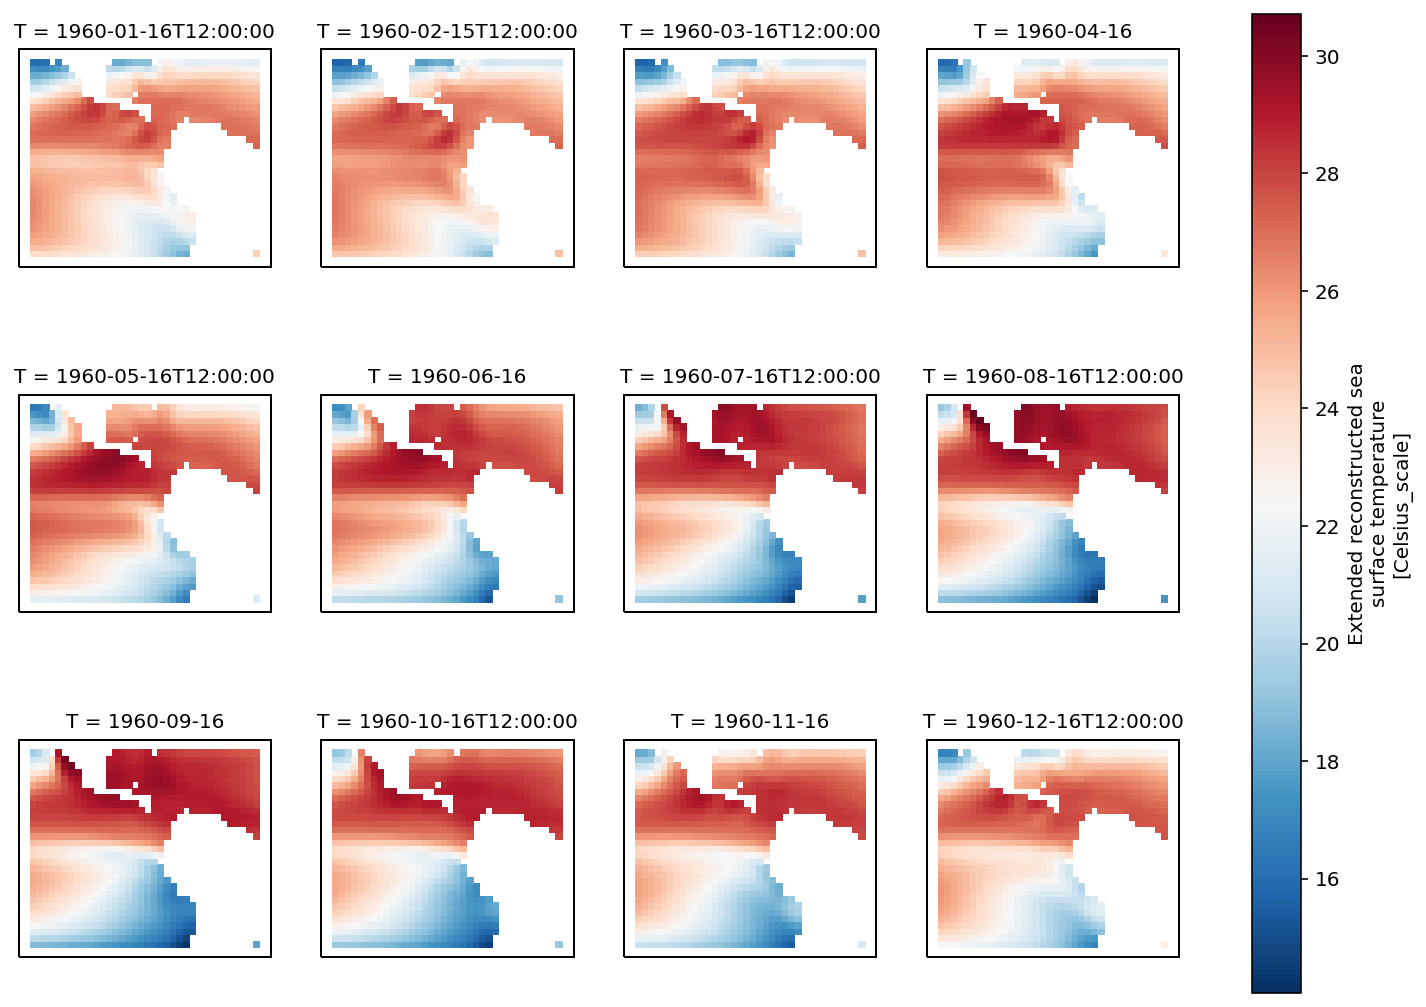

In [22]:
g = sst_climo_ds.sst.plot(x='X', y='Y', col='T', col_wrap=4, cmap='RdBu_r', subplot_kws={'projection': ccrs.PlateCarree()}, infer_intervals=True);

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/plot/facetgrid.py:373: UserWarning: Tight layout not applied. tight_layout cannot make axes width small enough to accommodate all axes decorations
  self.fig.tight_layout()
/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:782: MatplotlibDeprecationWarning: Passing the minor parameter of set_xticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_xticks(xticks, minor)
/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/cartopy/mpl/geoaxes.py:829: MatplotlibDeprecationWarning: Passing the minor parameter of set_yticks() positionally is deprecated since Matplotlib 3.2; the parameter will become keyword-only two minor releases later.
  return super(GeoAxes, self).set_yticks(yticks, minor)


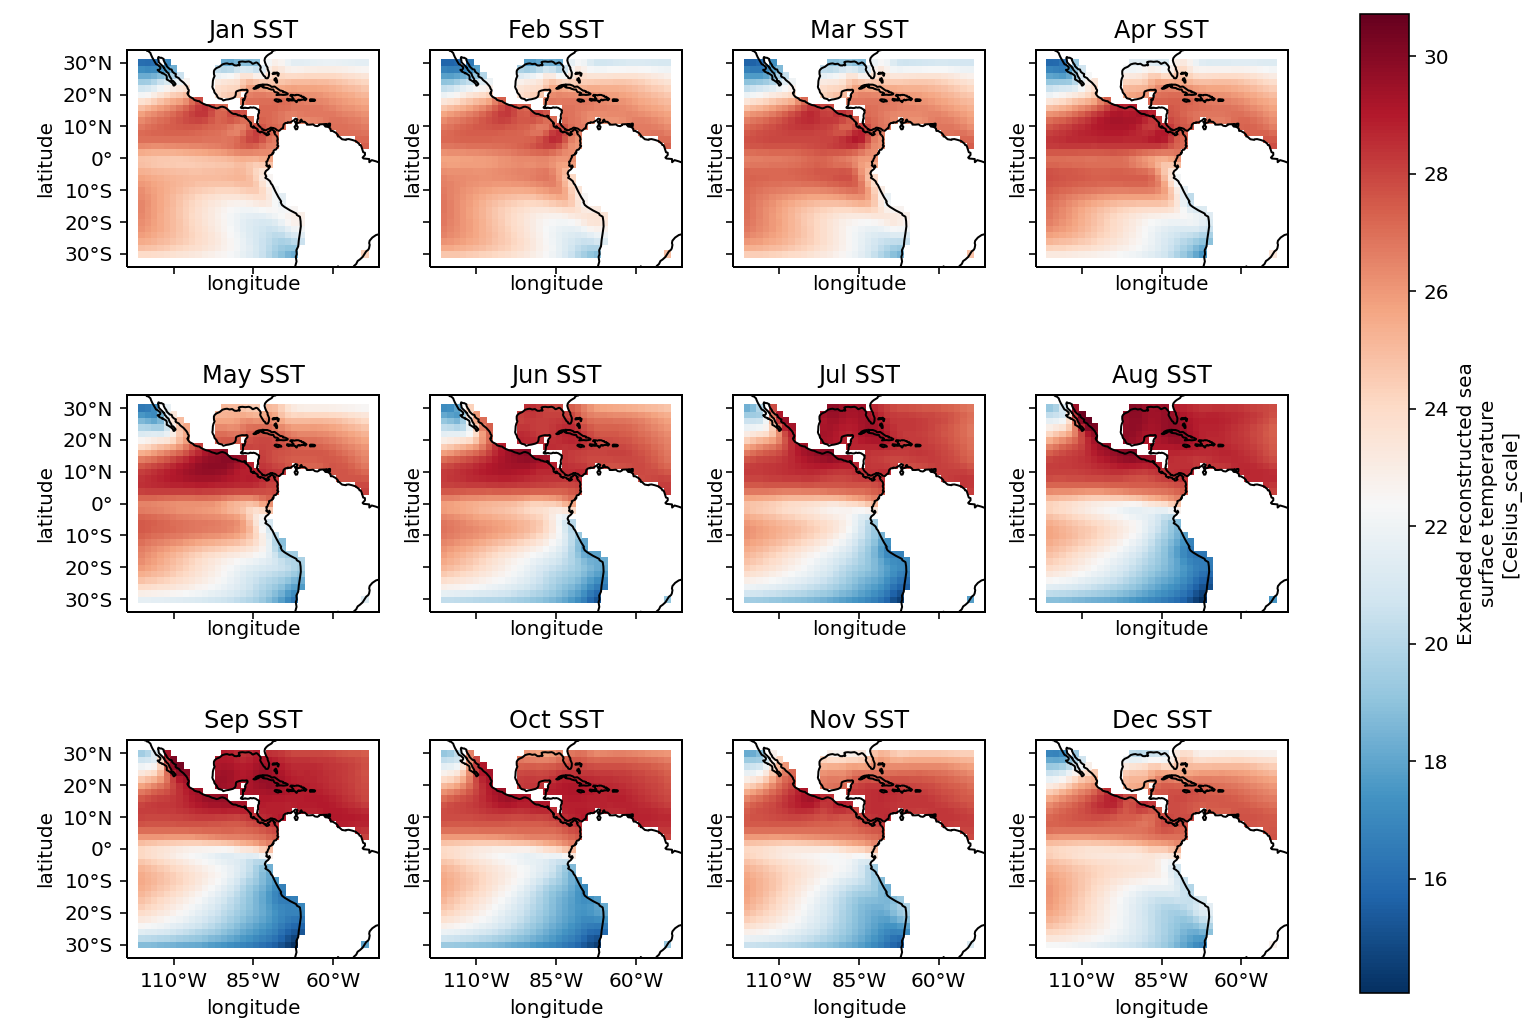

In [23]:
import xarray as xr
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

XY_str = 'X/240/310/RANGE/Y/-30/30/RANGE/'
sst_climo_url = 'https://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/T/(Jan%201981)/(Dec%202010)/RANGE/yearly-climatology/' + XY_str + 'zlev/removeGRID/T/(days%20since%201960-01-01)streamgridunitconvert/dods'
sst_climo_ds = xr.open_dataset(sst_climo_url)

g = sst_climo_ds.sst.plot.pcolormesh(x='X', y='Y', col='T', col_wrap=4, cmap='RdBu_r', subplot_kws={'projection': ccrs.PlateCarree()}, infer_intervals=True);
for ii, ax in enumerate(g.axes.flat):
    ax.set_title(month_str[ii] + ' SST')
    ax.coastlines()
    ax.set_xticks(np.arange(200,325,25)-360)
    ax.set_yticks(np.arange(-30,30+10,10))
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.set_xlabel('longitude')
    ax.set_ylabel('latitude')

### Bar plot with more than one bar

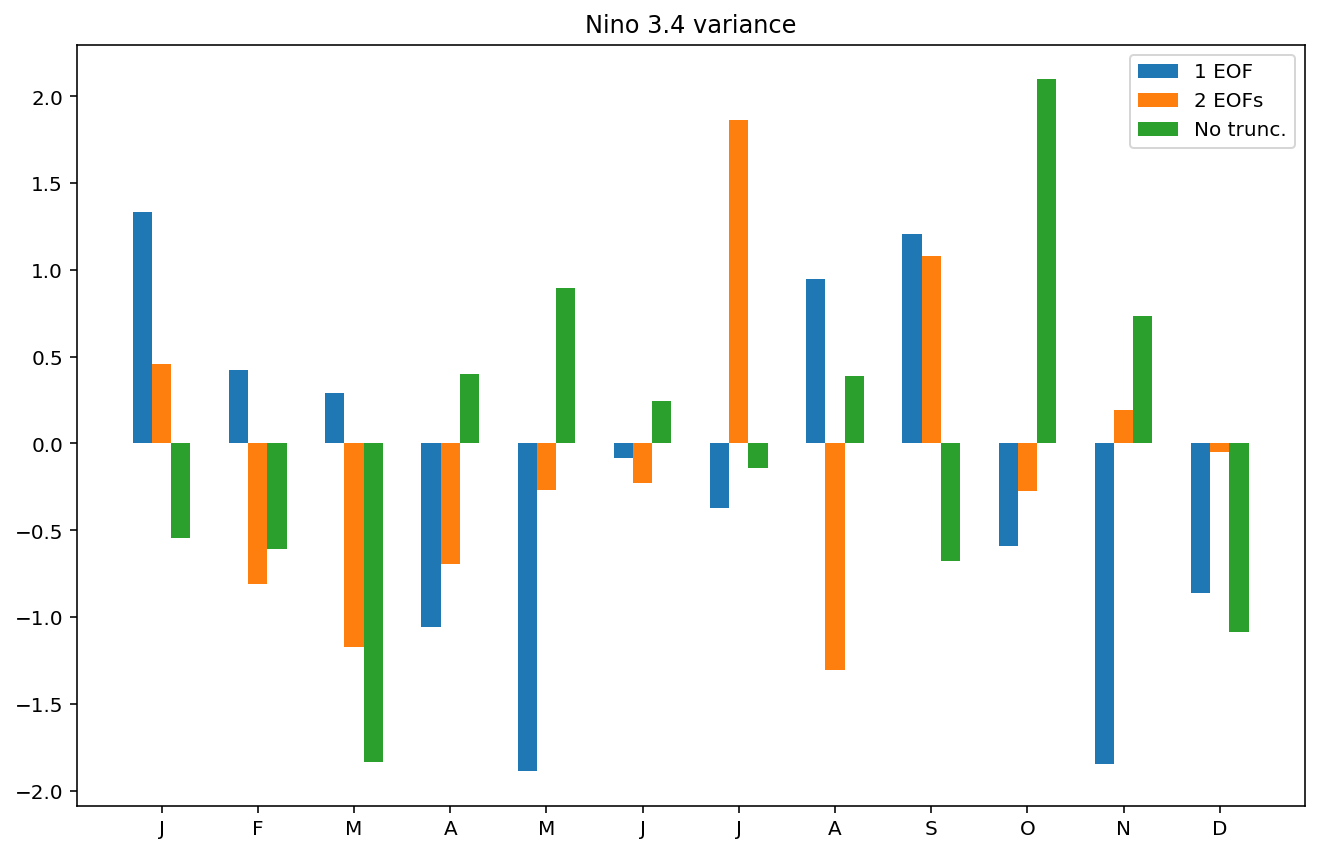

In [24]:
dta = np.random.normal(size=(3,12))
fig, ax = plt.subplots(figsize=(11, 7))
fig.set_facecolor("white")

width = 0.2
ax.bar(np.arange(1,12+1) - width,dta[0,:],width,label='1 EOF');
ax.bar(np.arange(1,12+1)        ,dta[1,:],width,label='2 EOFs');
ax.bar(np.arange(1,12+1) + width,dta[2,:],width,label='No trunc.');


ax.legend();
plt.xticks(np.arange(1,12+1),m_str);
plt.title('Nino 3.4 variance');

### Month strings

In [25]:
from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str]
print(month_str)
print(m_str)

['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
['J', 'F', 'M', 'A', 'M', 'J', 'J', 'A', 'S', 'O', 'N', 'D']


### Checker board plots

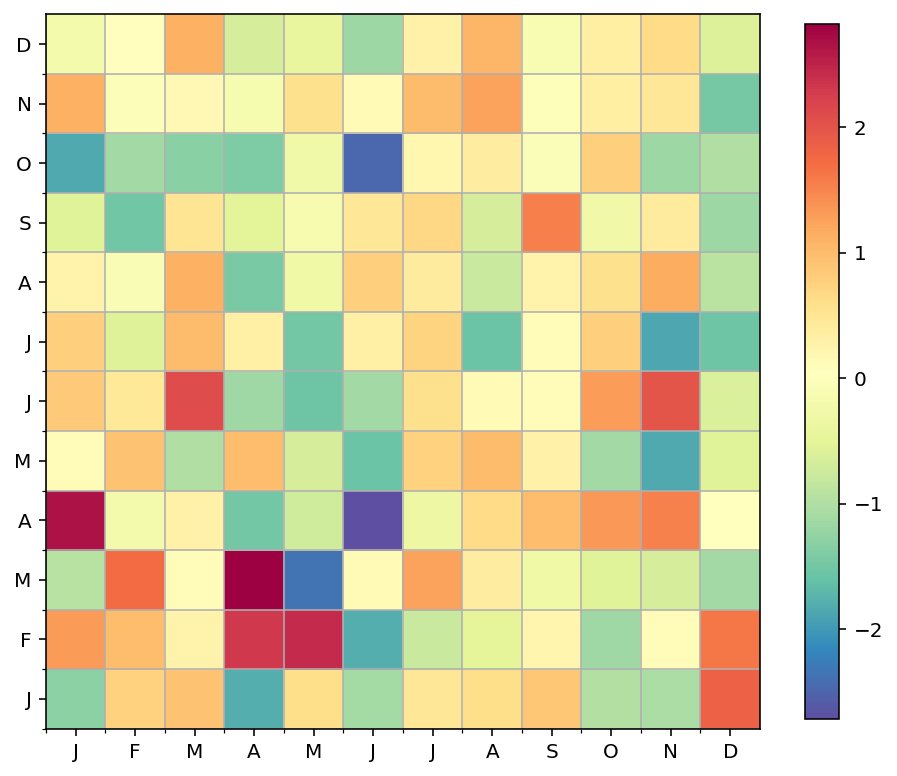

In [26]:
from matplotlib import cm

C = np.random.normal(size=(12,12))

fig, ax = plt.subplots(figsize=(8, 8))
fig.set_facecolor("white")

g = ax.pcolormesh(np.arange(0,12+1)+0.5, np.arange(0,12+1)+0.5, C, cmap=cm.Spectral_r);
ax.set_xticks(np.arange(0,12)+1);
ax.set_yticks(np.arange(0,12)+1);
ax.set_xticklabels(m_str)
ax.set_yticklabels(m_str)
ax.set_aspect(aspect=1)
plt.colorbar(g, ax=ax, shrink = 0.8);

ax.set_xticks(np.arange(0,12) + 0.5, minor=True);
ax.set_yticks(np.arange(0,12) + 0.5, minor=True);
plt.grid(which='minor')

In [27]:
C.shape

(12, 12)

### Shift an array (handy for converting from start-lead to target-lead)

In [28]:
a = np.arange(10)
print(a)
print(np.roll(a, 6))
print(np.roll(a, -6))

[0 1 2 3 4 5 6 7 8 9]
[4 5 6 7 8 9 0 1 2 3]
[6 7 8 9 0 1 2 3 4 5]


### Comprehension list

In [29]:
data = [ix + it + im for it in ('t1','t2','t3') for im in ('m1','m2','m3','m4') for ix in ('x1','x2')]
data

['x1t1m1',
 'x2t1m1',
 'x1t1m2',
 'x2t1m2',
 'x1t1m3',
 'x2t1m3',
 'x1t1m4',
 'x2t1m4',
 'x1t2m1',
 'x2t2m1',
 'x1t2m2',
 'x2t2m2',
 'x1t2m3',
 'x2t2m3',
 'x1t2m4',
 'x2t2m4',
 'x1t3m1',
 'x2t3m1',
 'x1t3m2',
 'x2t3m2',
 'x1t3m3',
 'x2t3m3',
 'x1t3m4',
 'x2t3m4']

In [30]:
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

### Formatting strings
https://pyformat.info

In [31]:
'{} {}'.format('one', 'two')

'one two'

In [32]:
'{1} {0}'.format('one', 'two')

'two one'

In [33]:
'pi = {:4.2f}'.format(3.141592653589793)

'pi = 3.14'

In [34]:
'{:+d}'.format(42)

'+42'

### Stage IV data

In [35]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

stageiv_ds = xr.open_dataset('https://cida.usgs.gov/thredds/dodsC/stageiv_combined')
stageiv_ds

In [58]:
p = stageiv_ds.Total_precipitation_surface_1_Hour_Accumulation.isel(time=-1)
p.load()

<xarray.DataArray 'Total_precipitation_surface_1_Hour_Accumulation' (y: 881, x: 1121)>
array([[nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       ...,
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan],
       [nan, nan, nan, ..., nan, nan, nan]], dtype=float32)
Coordinates:
    lon      (x, y) float32 -119.022995 -119.031425 ... -59.99116 -59.951366
    lat      (x, y) float32 23.117 23.14802 23.179047 ... 45.59089 45.618702
    time     datetime64[ns] 2020-11-24T06:00:00
Dimensions without coordinates: y, x
Attributes:
    long_name:      Total precipitation (1_Hour Accumulation) @ Ground or wat...
    description:    Total precipitation
    units:          kg m^-2
    _ChunkSizes:    [ 1 60 75]
    standard_name:  precipitation_amount
    cell_methods:   time: sum (interval: 1 hr)

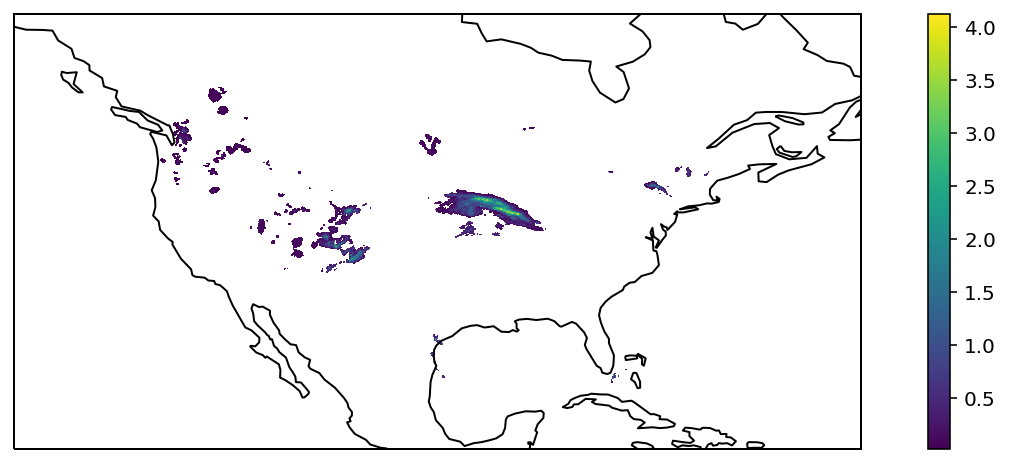

In [74]:
p.values[p==0] = np.nan
proj = ccrs.PlateCarree()

fig = plt.figure(figsize=(12,4))
ax = plt.subplot(projection=proj)

#stageiv_ds.Total_precipitation_surface_1_Hour_Accumulation.isel(time=-1).plot(cmap = 'Blues', vmax = 10)#, transform = proj, ax = ax);
g = ax.pcolormesh(stageiv_ds.lon, stageiv_ds.lat, p.T, transform = proj);
ax.coastlines();
plt.colorbar(g);

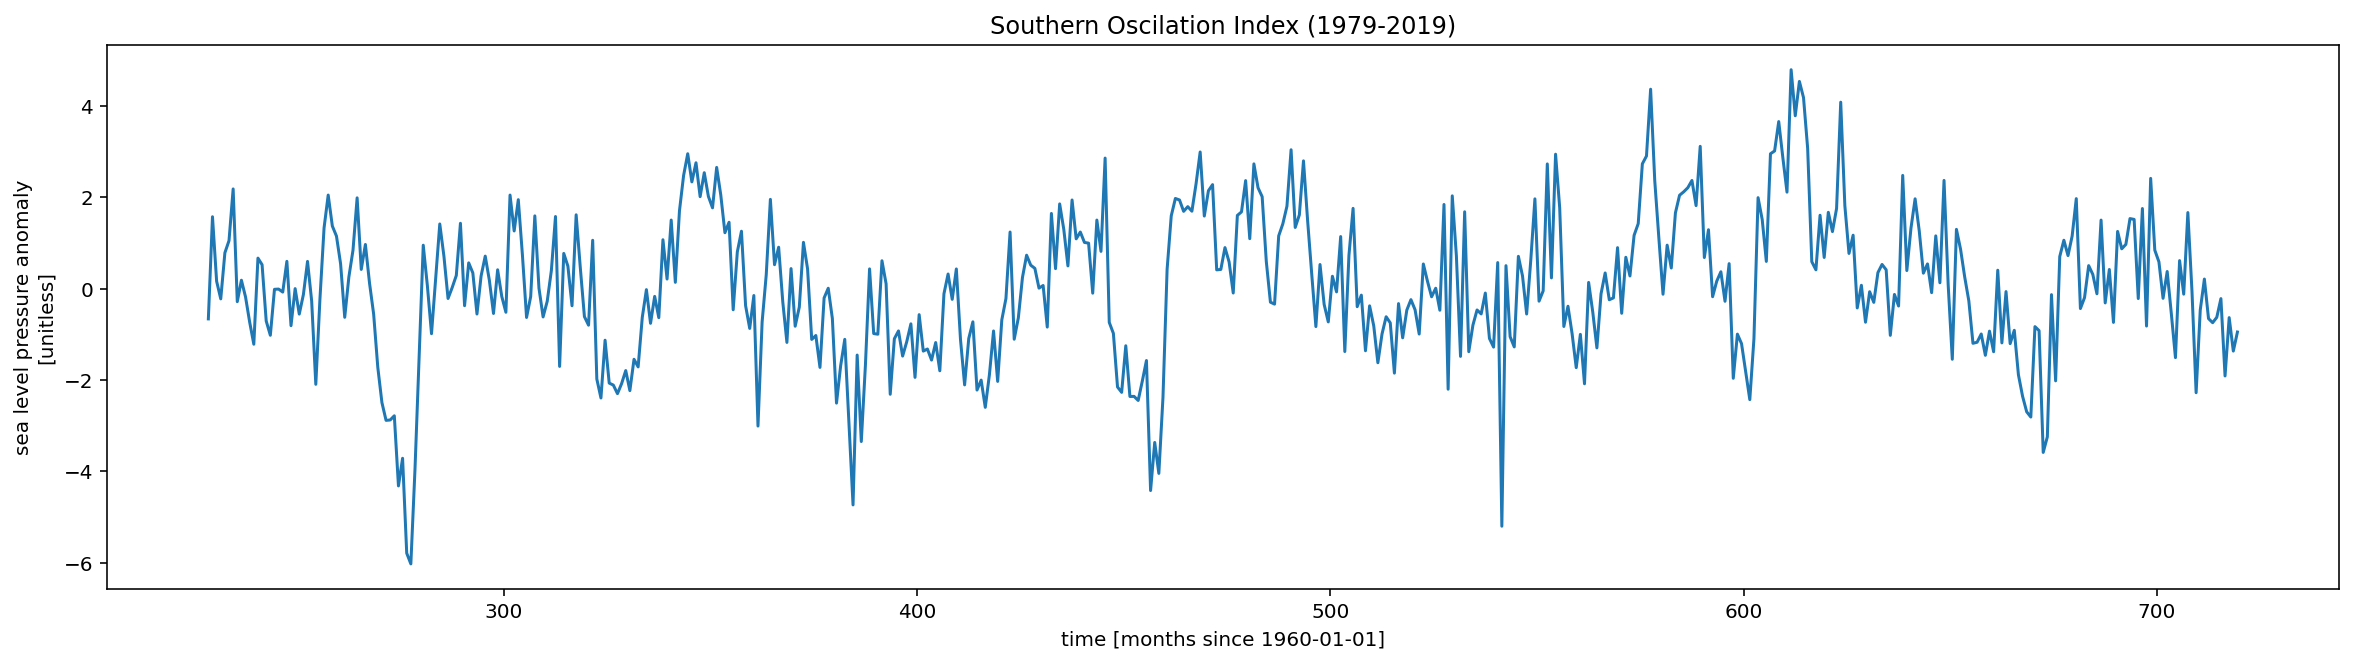

In [37]:
import xarray as xr
from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

soi_url_does_NOT_work = 'http://iridl.ldeo.columbia.edu/SOURCES/.Indices/.soi/.c8110/.anomaly/T/%28Jan%201979%29/%28Dec%202019%29/RANGE/dods'
soi_url_does_work = 'http://iridl.ldeo.columbia.edu/SOURCES/.Indices/.soi/.c8110/.anomaly/dods'
soi_ds = xr.open_dataset(soi_url_does_NOT_work,decode_times=False)
fig, ax = plt.subplots(figsize=(20,5))
soi_ds.anomaly.plot();
plt.title('Southern Oscilation Index (1979-2019)');

In [38]:
xr.__version__

'0.16.0'

In [39]:
import netCDF4
netCDF4.Dataset(soi_url_does_NOT_work)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: IRIDL
    dimensions(sizes): T(492)
    variables(dimensions): float32 T(T), float32 anomaly(T)
    groups: 

In [40]:
netCDF4.__version__

'1.4.2'

In [41]:
import netCDF4
soi_url_does_NOT_work = 'http://iridl.ldeo.columbia.edu/SOURCES/.Indices/.soi/.c8110/.anomaly/T/%28Jan%201979%29/VALUE/dods'
netCDF4.Dataset(soi_url_does_NOT_work)

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF3_CLASSIC data model, file format DAP2):
    Conventions: IRIDL
    dimensions(sizes): T(1)
    variables(dimensions): float32 T(T), float32 anomaly(T)
    groups: 

### Read ingrid times

In [42]:
import cftime
cftime.__version__

'1.2.1'

In [43]:
import xarray as xr

url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.CAMS_OPI/.v0208/.mean/.prcp/dods'
ds = xr.open_dataset(url,decode_times=False)

In [44]:
def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

ds = fix_calendar(ds)
ds = xr.decode_cf(ds)
ds

<xarray.Dataset>
Dimensions:  (T: 502, X: 144, Y: 72)
Coordinates:
  * Y        (Y) float32 -88.75 -86.25 -83.75 -81.25 ... 81.25 83.75 86.25 88.75
  * X        (X) float32 1.25 3.75 6.25 8.75 ... 351.25 353.75 356.25 358.75
  * T        (T) object 1979-01-16 00:00:00 ... 2020-10-16 00:00:00
Data variables:
    prcp     (T, Y, X) float32 ...
Attributes:
    Conventions:  IRIDL

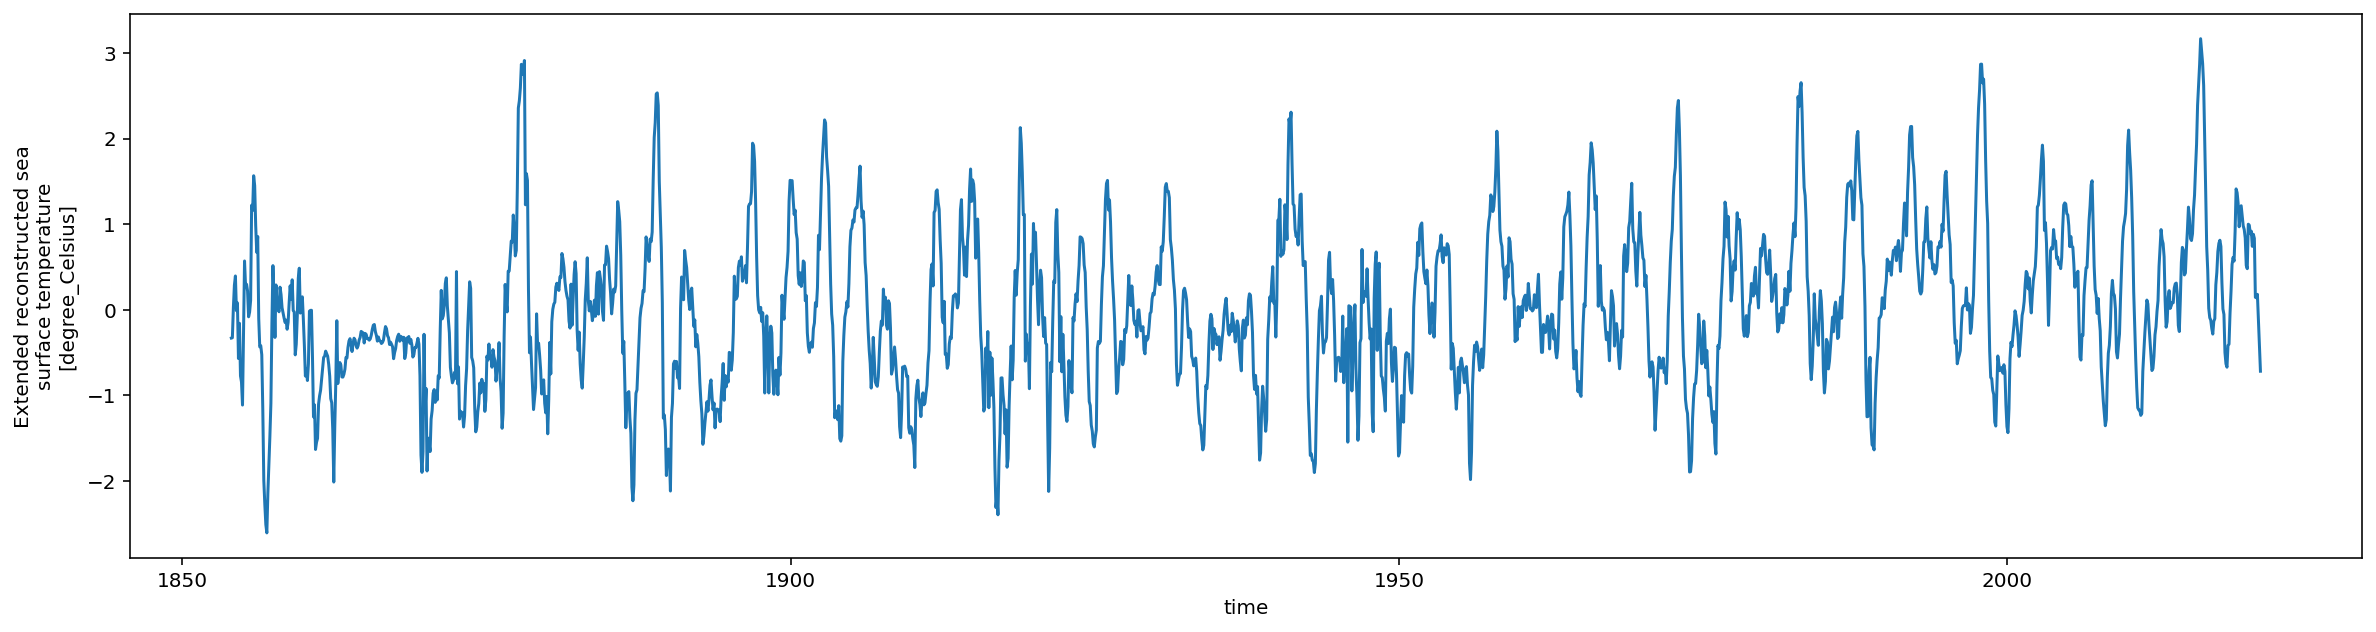

In [45]:
import xarray as xr
from matplotlib import pyplot as plt
import cftime

# function to help xarray understand months
def fix_calendar(ds, timevar='T'):
    if ds[timevar].attrs['calendar'] == '360':
        ds[timevar].attrs['calendar'] = '360_day'
    return ds

dl_url = 'http://iridl.ldeo.columbia.edu/'
ERSSTv5_url = 'SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/'
n34box_url = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/[X/Y]average/'
n34_url = dl_url + ERSSTv5_url + n34box_url + "zlev/removeGRID/yearly-anomalies/dods"

n34_ds = xr.open_dataset(n34_url,decode_times=False)
n34_ds = fix_calendar(n34_ds)
n34_ds = xr.decode_cf(n34_ds)

fig, ax = plt.subplots(figsize=(20,5))
n34_ds.sst.plot();

In [46]:
cftime.__version__

'1.2.1'

In [47]:
xr.__version__

'0.16.0'

In [48]:
import matplotlib
matplotlib.__version__

'3.2.2'

In [49]:
import numpy as np
np.__version__

'1.19.1'

### Apply a function to an xarray dataset/dataarray

Apply KS test to all the grid points comparing to sets of time indices

In [50]:
import xarray as xr
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

def ks_test_map(x, t_ind1, t_ind2):
    ks_statistic,p_value = stats.ks_2samp(x.isel(T = t_ind1),x.isel(T = t_ind2))
    return xr.DataArray(p_value) 

global_prcp = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.CPC/.Merged_Analysis/.monthly/.latest/.ver2/.prcp_est/'
t_range = 'T/%28Jan%201979%29/%28Aug%202020%29/RANGE/'
JJA = 'T/3/runningAverage/T/%28Jun-Aug%29VALUES/'
t_fix = 'T/(days%20since%201960-01-01)streamgridunitconvert/'
prcp_url = global_prcp + JJA + t_fix + 'dods'
prcp_ds = xr.open_dataset(prcp_url, decode_times=False)

nino34 ='http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/zlev/removeGRID/'
nino34_url = nino34 + t_range + JJA + t_fix + 'dods'
n34_ds = xr.open_dataset(nino34_url, decode_times=False)

n34 = n34_ds.sst - n34_ds.sst.mean() 
t_nina = n34.values <= -0.4
t_nino = n34.values >= 0.33

da = prcp_ds.prcp_est
stacked = da.stack(allpoints=['X','Y'])  

p_map = stacked.groupby('allpoints').map(ks_test_map, args=(t_nina, t_nino))
p_map = p_map.unstack('allpoints')

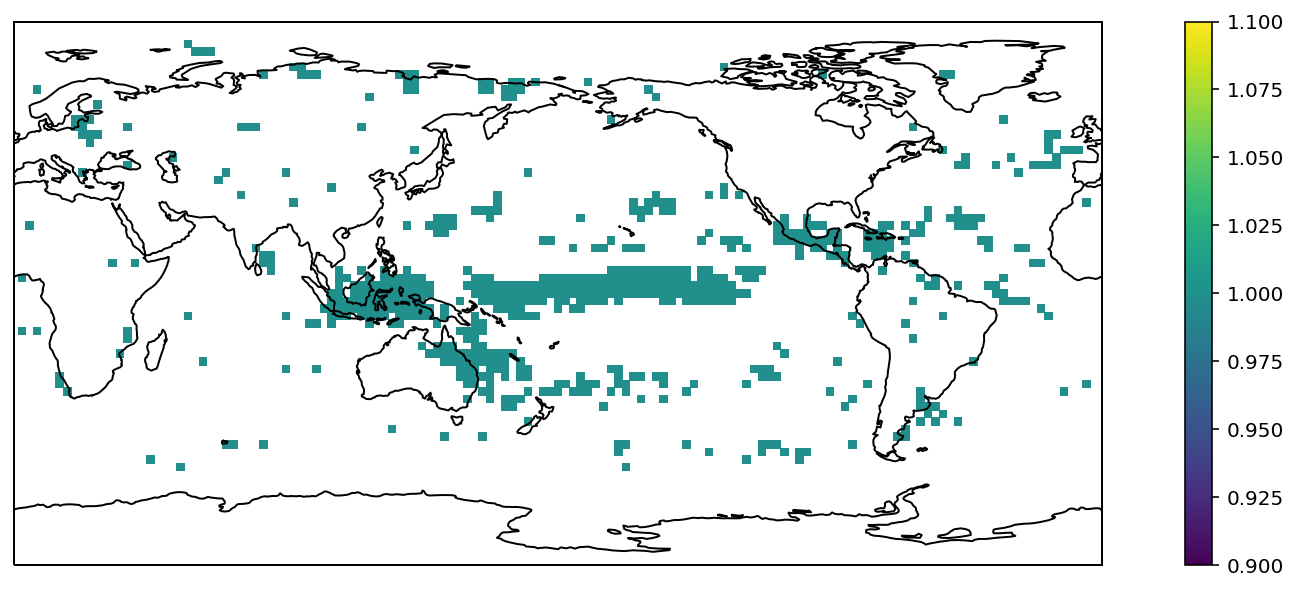

In [51]:
import numpy as np 
sig_map = p_map.values.copy()
sig_map[p_map < 0.05] = 1.
sig_map[p_map >= 0.05] = np.nan

proj_map = ccrs.PlateCarree(central_longitude=180)
proj_dta = ccrs.PlateCarree()

fig = plt.figure(figsize=(15,5))
ax = plt.subplot(projection=proj_map)

plt.pcolormesh(ds.X, ds.Y, sig_map.T, transform = proj_dta, vmax=1);
ax.coastlines();
plt.colorbar();

### Get color order

In [52]:
# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

In [53]:
colors

['#1f77b4',
 '#ff7f0e',
 '#2ca02c',
 '#d62728',
 '#9467bd',
 '#8c564b',
 '#e377c2',
 '#7f7f7f',
 '#bcbd22',
 '#17becf']

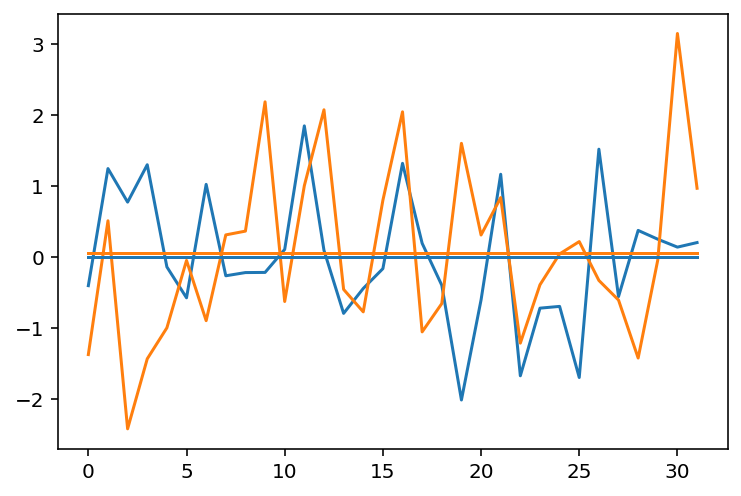

In [54]:
x = np.random.normal(size=32)
y = np.random.normal(size=32)
plt.plot(x)
plt.plot(y)
plt.plot(np.mean(x) + 0.0*x, color=colors[0])
plt.plot(np.mean(y) + 0.0*y, color=colors[1])

### Count number of trues

In [55]:
count = np.count_nonzero(bool_array)

NameError: name 'bool_array' is not defined

#### Lag correlation

In [440]:
#DOES NOT DO WHAT YOU THINK IT DOES!!!!!!!!!!!!!!!!!
Xt = n34a[1:]
Xt_1 = n34a[:-1]
R = Xt - phi*Xt_1 - k

NameError: name 'phi' is not defined

# Read ERA 5 from AWS

In [446]:
import xarray as xr
import datetime
import numpy as np
import s3fs
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap

In [447]:
def open_zarrs(year, month, datestart, dateend):
    fs = s3fs.S3FileSystem(anon=True)
    
    datestring = 'era5-pds/zarr/{year}/{month:02d}/data/'.format(year=year, month=month)
    
    mslp_zarr = xr.open_zarr(s3fs.S3Map(datestring + 'air_pressure_at_mean_sea_level.zarr/', s3=fs))
    mslp_zarr = mslp_zarr.sel(time0=slice(np.datetime64(datestart), np.datetime64(dateend)))
    
    airt_zarr = xr.open_zarr(s3fs.S3Map(datestring + 'air_temperature_at_2_metres.zarr/', s3=fs))
    airt_zarr = airt_zarr.sel(time0=slice(np.datetime64(datestart), np.datetime64(dateend)))
    
    precip_zarr = xr.open_zarr(s3fs.S3Map(datestring + 'precipitation_amount_1hour_Accumulation.zarr/', s3=fs))
    precip_zarr = precip_zarr.sel(time1=slice(np.datetime64(datestart), np.datetime64(dateend)))
    
    return (mslp_zarr, airt_zarr, precip_zarr)

In [459]:
mslp, airt, precip = open_zarrs(1987, 12, '1987-12-01', '1987-12-21 23:59')
precip

<xarray.Dataset>
Dimensions:                                  (lat: 721, lon: 1440, nv: 2, time1: 504)
Coordinates:
  * lat                                      (lat) float32 90.0 89.75 ... -90.0
  * lon                                      (lon) float32 0.0 0.25 ... 359.75
  * time1                                    (time1) datetime64[ns] 1987-12-0...
Dimensions without coordinates: nv
Data variables:
    precipitation_amount_1hour_Accumulation  (time1, lat, lon) float32 dask.array<chunksize=(372, 150, 150), meta=np.ndarray>
    time1_bounds                             (time1, nv) datetime64[ns] dask.array<chunksize=(504, 2), meta=np.ndarray>
Attributes:
    institution:  ECMWF
    source:       Reanalysis
    title:        ERA5 forecasts

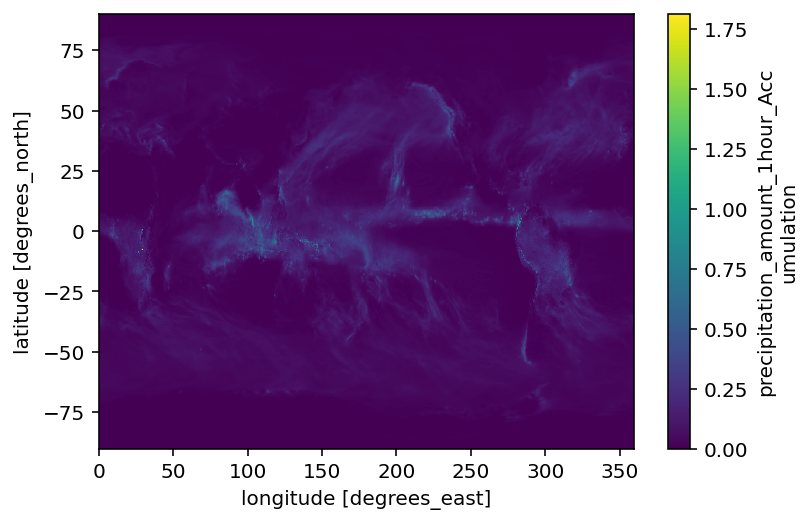

In [460]:
precip.precipitation_amount_1hour_Accumulation.sum('time1').plot()

## Read CMAP ESRL

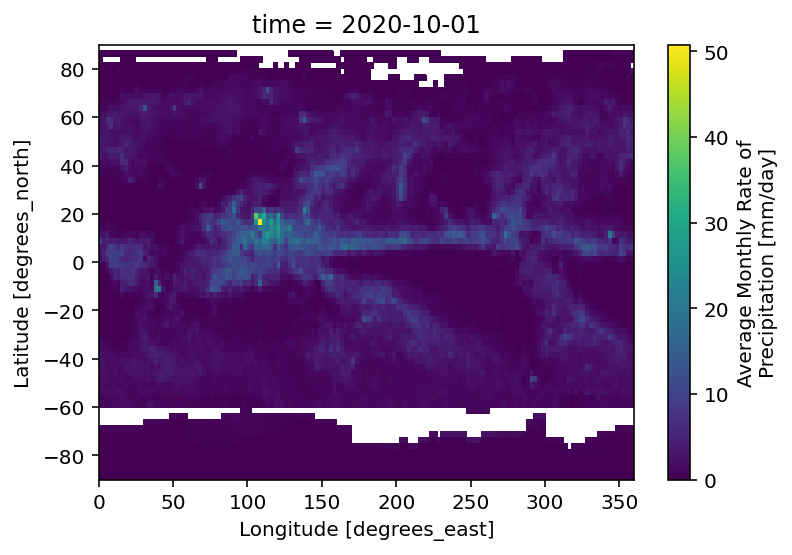

In [509]:
cmap_ds = xr.open_dataset('https://psl.noaa.gov/thredds/dodsC/Datasets/cmap/std/precip.mon.mean.nc')
cmap_ds.precip.isel(time = -1).plot()

# Read daily OLR THREDDS

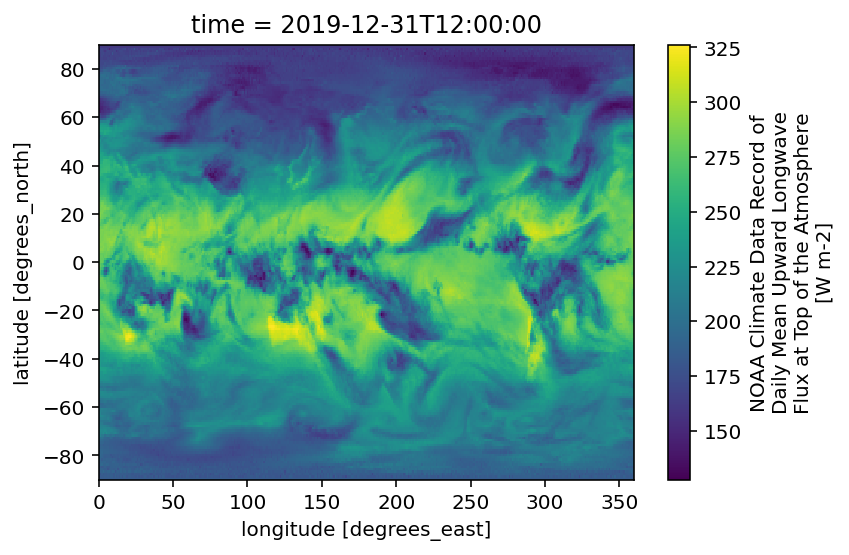

In [442]:
baseurl = 'https://www.ncei.noaa.gov/thredds/dodsC/cdr/olr-daily/olr-daily_v01r02_' 
urls = [baseurl + '{0}0101_{0}1231.nc'.format(years) for years in range(1979, 2020)]
olr_ds = xr.open_mfdataset(urls)
olr_ds.olr[-1].plot();

In [445]:
xr.__version__

'0.16.0'

# Read HURDAT2 data

In [111]:
import pandas as pd
from datetime import datetime
import cartopy.crs as ccrs
import cartopy.feature as cfeature

def lat_lon_to_float (v):
    if (v[-1] == 'S') or (v[-1] == 'W'):
        multiplier = -1
    else:
        multiplier = 1
    return float(v[:-1]) * multiplier

In [118]:
# format info https://www.nhc.noaa.gov/data/hurdat/hurdat2-format-nov2019.pdf
!curl --silent https://www.nhc.noaa.gov/data/hurdat/hurdat2-1851-2019-052520.txt -o hurdat2-1851-2019-052520.txt

data = []

with open('hurdat2-1851-2019-052520.txt', 'r') as f:
    for line in f.readlines():
        if line.startswith('AL'):
            storm_id = line.split(',')
            storm_number = storm_id[0].strip()
            storm_name = storm_id[1].strip()
        else:
            location_line = line.split(',')
            dt = datetime.strptime(location_line[0] + location_line[1], '%Y%m%d %H%M')
            storm_status = location_line[3].strip()
            storm_lat = lat_lon_to_float(location_line[4].strip())
            storm_lon = lat_lon_to_float(location_line[5].strip())
            max_speed  = float(location_line[6].strip())
            data.append([storm_number, storm_name, storm_status, storm_lat, storm_lon, dt, max_speed])

In [119]:
data[0]

['AL011851',
 'UNNAMED',
 'HU',
 28.0,
 -94.8,
 datetime.datetime(1851, 6, 25, 0, 0),
 80.0]

In [120]:
df = pd.DataFrame(data, columns = ['Storm Number', 'Storm Name', 'Storm Status', 'Lat', 'Lon', 'Time', 'Max Speed'])

In [121]:
df.head()

Storm Number Storm Name Storm Status   Lat   Lon                Time  \
0     AL011851    UNNAMED           HU  28.0 -94.8 1851-06-25 00:00:00   
1     AL011851    UNNAMED           HU  28.0 -95.4 1851-06-25 06:00:00   
2     AL011851    UNNAMED           HU  28.0 -96.0 1851-06-25 12:00:00   
3     AL011851    UNNAMED           HU  28.1 -96.5 1851-06-25 18:00:00   
4     AL011851    UNNAMED           HU  28.2 -96.8 1851-06-25 21:00:00   

   Max Speed  
0       80.0  
1       80.0  
2       80.0  
3       80.0  
4       80.0

In [149]:
plot_crs = ccrs.LambertConformal(central_longitude = -90, central_latitude = 45)
data_crs = ccrs.PlateCarree()

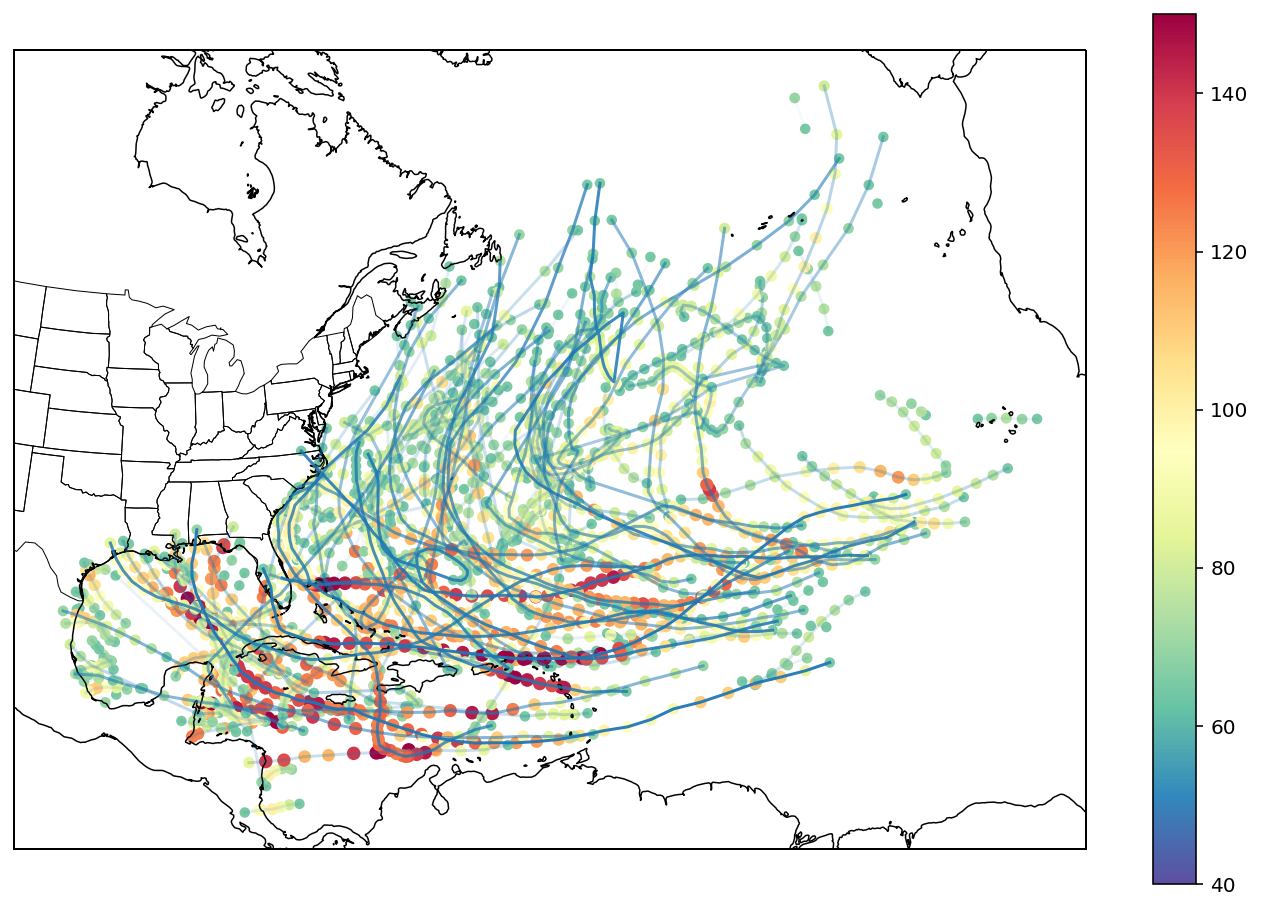

In [151]:
fig = plt.figure(figsize = (12, 8))
ax = plt.subplot(1, 1, 1, projection = plot_crs)
ax.set_extent = (-100, -37, 12,  52, data_crs)
ax.coastlines('50m', edgecolor ='k', linewidth = 0.75)
ax.add_feature(cfeature.STATES, linewidth = 0.5)

df_hu = df[df['Storm Status'] == 'HU']
df_hu = df_hu[df_hu['Time'] > datetime(2020 - 20 , 1 ,1)]

for storm_number in df_hu['Storm Number'].unique():
    storm_data = df_hu[df_hu['Storm Number'] == storm_number]
    track_len = len(storm_data)
    ax.plot(storm_data['Lon'], storm_data['Lat'], transform = data_crs,
           color = 'tab:blue', alpha = track_len / 55)
    s = ax.scatter(storm_data['Lon'], storm_data['Lat'],
                  transform = data_crs, c = storm_data['Max Speed'],
                  vmin = 40, vmax = 150, s = 5 * (1 + storm_data['Max Speed']/25), cmap = 'Spectral_r')
plt.colorbar(s); 

In [152]:
3/55

0.05454545454545454

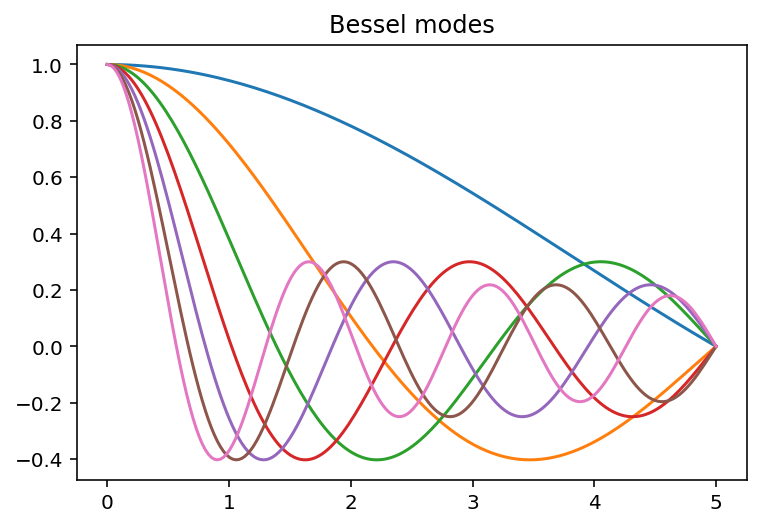

In [422]:
from scipy.special import jn
from scipy.special import jn_zeros

#symmetric
m = 0 
#number of modes
N = 7
# boundary at r = a
a = 5
nr = 200
r = np.linspace(0, a, nr).reshape(nr, 1)
z_mn = jn_zeros(m, N).reshape(1, N)
w_mn = yn_zeros(m, N).reshape(1, N)

Gamma_mn = (w_mn/a)**2
Lambda_mn = (z_mn/a)**2

plt.plot(r, jn(m, np.sqrt(Lambda_mn)*r));
plt.title('Bessel modes');

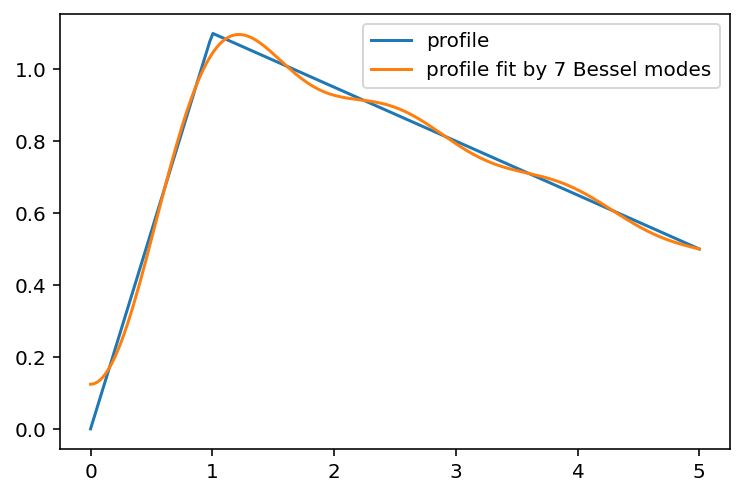

In [430]:
b = 1
profile = r * (r < b) + b * (1 - r/a)/(1 - b/a) * (r > b) + 0.5 * r/a 
from numpy.linalg import inv

A = jn(m, np.sqrt(Lambda_mn)*r)
x_hat = inv(A.T @ A) @ (A.T @ (profile - profile[-1]))
profile_hat = A @ x_hat + profile[-1]
plt.plot(r, profile, label = 'profile')
plt.plot(r, profile_hat, label = 'profile fit by 7 Bessel modes');
plt.legend();

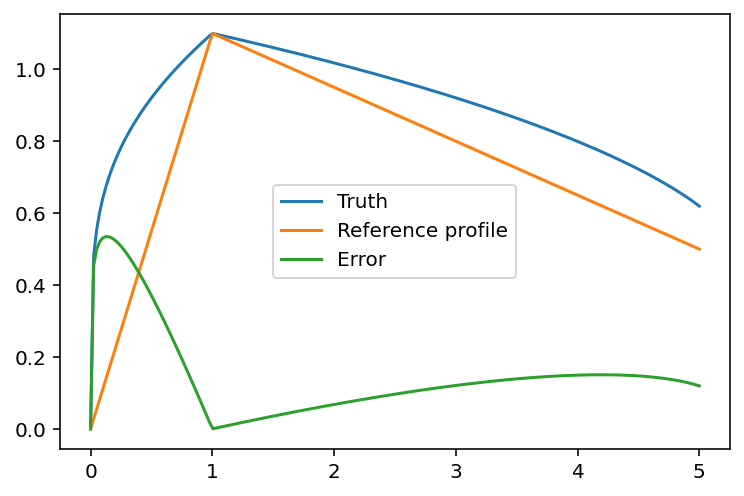

In [431]:
Truth = (r < b) * (r * b)**0.2 + b * ((1 - r/a/1.05)/(1 - b/a/1.05))**0.75 * (r > b) + 0.5 * r/a 

error = Truth - profile
plt.plot(r, Truth, label = 'Truth')
plt.plot(r, profile, label = 'Reference profile');
plt.plot(r, error, label = 'Error');
plt.legend();

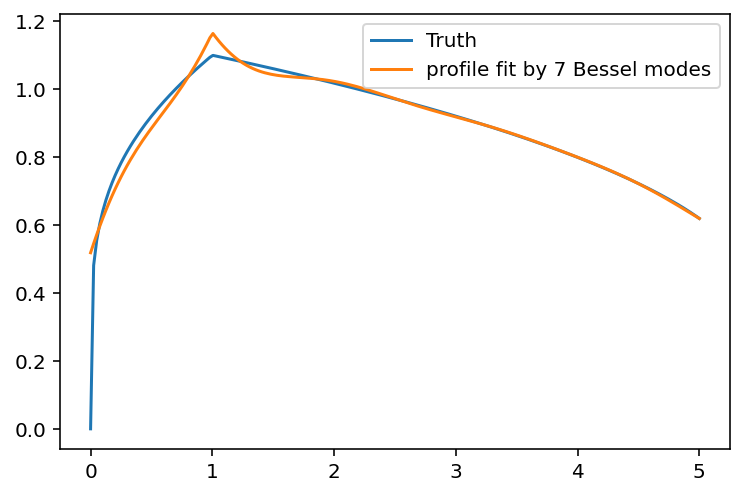

In [432]:
x_hat = inv(A.T @ A) @ (A.T @ (error - error[-1]))
error_hat = A @ x_hat + error[-1]
plt.plot(r, Truth, label = 'Truth')
plt.plot(r, profile + error_hat, label = 'profile fit by 7 Bessel modes');
plt.legend();

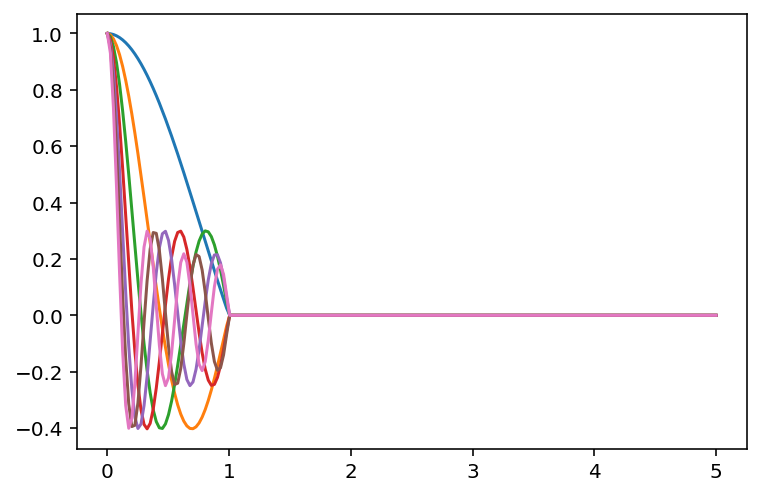

In [437]:
from scipy.special import yn
from scipy.special import yn_zeros

Lambda_mn_b = (z_mn/b)**2
Gamma_mn_b = (w_mn/b)**2

A = (r < b) * jn(m, np.sqrt(Lambda_mn_b) * r ) 
plt.plot(r, A);

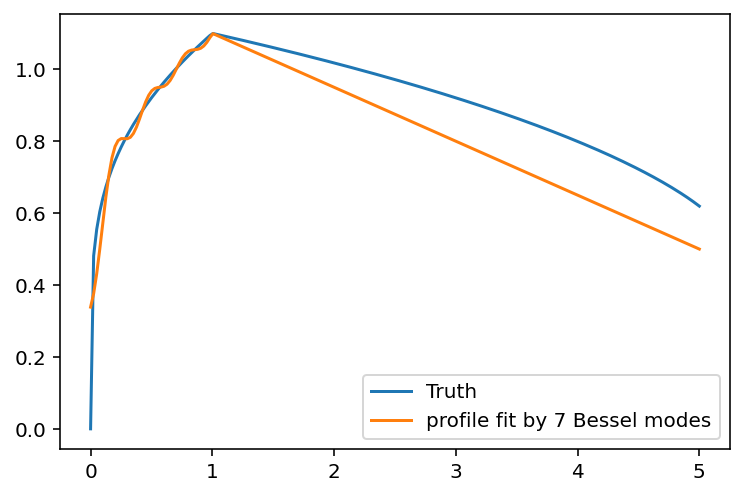

In [438]:
x_hat = inv(A.T @ A) @ (A.T @ (error))
error_hat = A @ x_hat
plt.plot(r, Truth, label = 'Truth')
plt.plot(r, profile + error_hat, label = 'profile fit by 7 Bessel modes');
plt.legend();

In [421]:
A[0,]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1.])

In [404]:
jn(m, np.sqrt(Lambda_mn_b) * r )

array([[ 1.        ,  1.        ,  1.        , ...,  1.        ,
         1.        ,  1.        ],
       [ 0.99908748,  0.99519667,  0.98821589, ...,  0.96512414,
         0.94912066,  0.93024028],
       [ 0.99635242,  0.98085589,  0.95327987, ...,  0.8641384 ,
         0.80422653,  0.73550277],
       ...,
       [ 0.02580079,  0.02589866, -0.04363309, ..., -0.06051333,
         0.06475029, -0.06706168],
       [ 0.03953736,  0.00483891, -0.01800239, ..., -0.03044228,
         0.03438262, -0.03755808],
       [ 0.05306079, -0.01620744,  0.00834479, ...,  0.00370095,
        -0.00278185,  0.00218859]])

In [389]:
A = (r < b) * jn(m, np.sqrt(Lambda_mn_b) * r ) + (r >= b) * yn(m, np.sqrt(Gamma_mn_b) * r ) 
A

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in multiply
  """Entry point for launching an IPython kernel.


array([[        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [ 0.99908748,  0.99519667,  0.98821589, ...,  0.96512414,
         0.94912066,  0.93024028],
       [ 0.99635242,  0.98085589,  0.95327987, ...,  0.8641384 ,
         0.80422653,  0.73550277],
       ...,
       [-0.17076454, -0.00933468,  0.03623291, ...,  0.05753681,
        -0.06289504,  0.06612721],
       [-0.17789736,  0.00856516,  0.01264602, ...,  0.02807276,
        -0.03252621,  0.03605074],
       [-0.1849048 ,  0.02629042, -0.01122085, ..., -0.00436913,
         0.00318706, -0.0024557 ]])

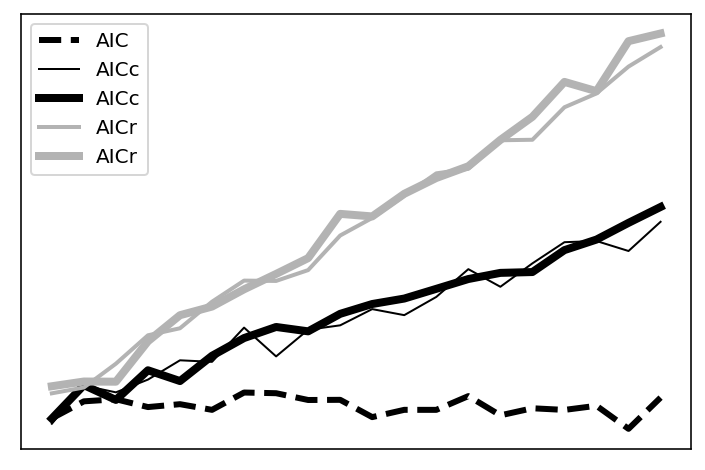

In [505]:
t = np.arange(0, 20)
dta = np.array([0*t + np.random.normal(size=20),
                t + np.random.normal(size=20), 
                1.1 * t + np.random.normal(size=20), 
                2 * t + np.random.normal(size=20), 
                2.1 * t + np.random.normal(size=20)])

plt.plot(dta[0, :], '--', linewidth = 3, color = (0, 0, 0), label = 'AIC');
plt.plot(dta[1, :], linewidth = 1, color = (0., 0., 0.), label = 'AICc');
plt.plot(dta[2, :], linewidth = 4, color = (0., 0., 0.), label = 'AICc');
plt.plot(dta[3, :], linewidth = 2, color = (0.7, 0.7, 0.7), label = 'AICr');
plt.plot(dta[4, :], linewidth = 4, color = (0.7, 0.7, 0.7), label = 'AICr');
plt.xticks([])
plt.yticks([])
plt.legend();

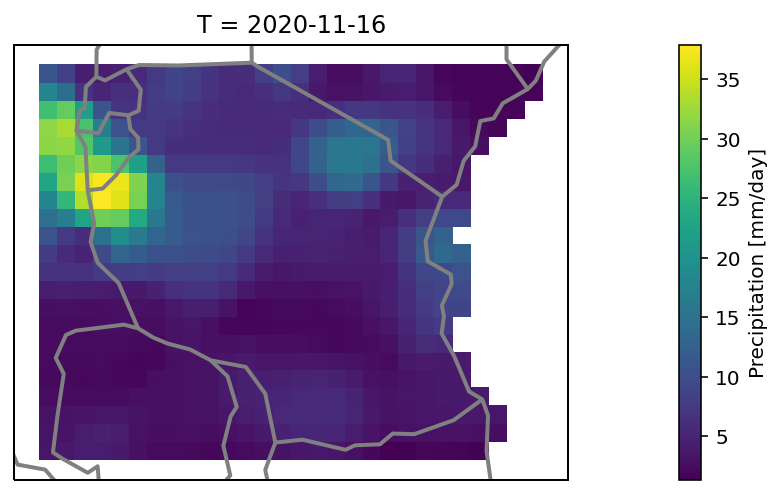

In [534]:
qa_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.Tanzania/.qa/0/pop/dods'
prcp_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.Tanzania/.prcp/dods'
t2m_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.Tanzania/.t2m/dods'
t2m_daily_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.Tanzania/.t2m_daily/dods'

prcp_ds = xr.open_dataset(prcp_url)
prcp = prcp_ds.prcp

proj = ccrs.PlateCarree()
fig = plt.figure(figsize = (20,4))
ax = plt.subplot(projection = proj)

prcp.isel(T = -1).plot(ax = ax, transform = proj)
ax.coastlines(color = 'gray', linewidth = 2)
ax.add_feature(cfeature.BORDERS, edgecolor='gray', linewidth = 2);

### Read data via curl

In [569]:
ds_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.Tanzania/.prcp/dods'
prcp_ds = xr.open_dataset(ds_url)
prcp_ds.load() #<-- Normally, it should not be necessary

<xarray.Dataset>
Dimensions:  (T: 503, X: 28, Y: 22)
Coordinates:
  * X        (X) float32 28.25 28.75 29.25 29.75 ... 40.25 40.75 41.25 41.75
  * Y        (Y) float32 -11.75 -11.25 -10.75 -10.25 ... -2.75 -2.25 -1.75 -1.25
  * T        (T) datetime64[ns] 1979-01-16T12:00:00 1979-02-15 ... 2020-11-16
Data variables:
    prcp     (T, Y, X) float32 4.459143 4.5295796 ... 1.6590719 1.5333422
Attributes:
    Conventions:  IRIDL

In [565]:
#Save it to a local file
nc_url = ds_url.replace('dods', 'data.nc')
!curl {nc_url} -o good_name.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 1213k  100 1213k    0     0  1071k      0  0:00:01  0:00:01 --:--:-- 1071k


In [568]:
prcp_ds = xr.open_dataset('good_name.nc')
prcp_ds

<xarray.Dataset>
Dimensions:  (T: 503, X: 28, Y: 22)
Coordinates:
  * Y        (Y) float32 -11.75 -11.25 -10.75 -10.25 ... -2.75 -2.25 -1.75 -1.25
  * X        (X) float32 28.25 28.75 29.25 29.75 ... 40.25 40.75 41.25 41.75
  * T        (T) datetime64[ns] 1979-01-16T12:00:00 1979-02-15 ... 2020-11-16
Data variables:
    prcp     (T, Y, X) float32 ...

In [146]:
#daily to monthly?
# https://xarray.pydata.org/en/v0.8.2/generated/xarray.Dataset.resample.html
data_2009 = last_data.resample(time='1M').mean()



(469, 60, 60)
(469, 60)


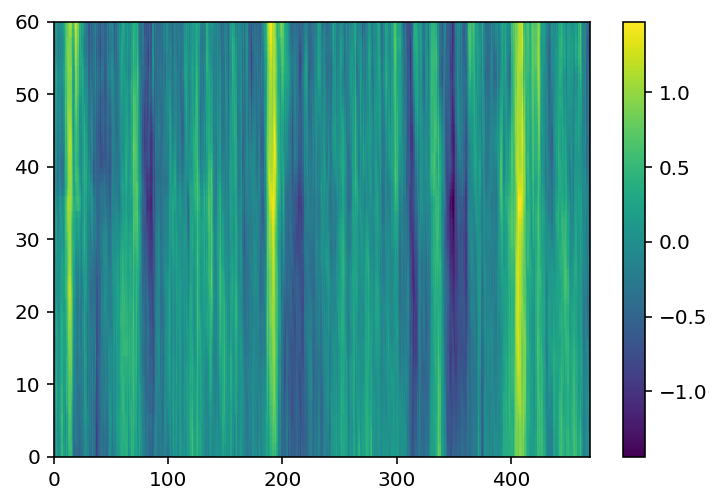

In [151]:
t_fix = 'T/(days)/32/string/(since)/32/string/(1960-01-01)/5/array/astore/concat/streamgridunitconvert/'

sst_url = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCEP/.EMC/.CMB/.GLOBAL/.Reyn_SmithOIv2/.monthly/.sst/' + t_fix + 'dods'
sst_ds = xr.open_dataset(sst_url)
sst_ds = sst_ds.sel(Y = slice(-30 , 30)).sel(X = slice(210,270))
sst = sst_ds.sst
s = sst.values
print(s.shape)
sy = np.mean(s, axis = 1)
print(sy.shape)
sya = sy.copy()
for ii in range(0, 12):
    sya[ii::12, :] = sy[ii::12, :] - np.mean(sy[ii::12, :], axis = 0)
plt.pcolor(sya.T)
plt.colorbar()

/Users/tippett/miniconda3/envs/pangeo/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


(874, 62, 152)


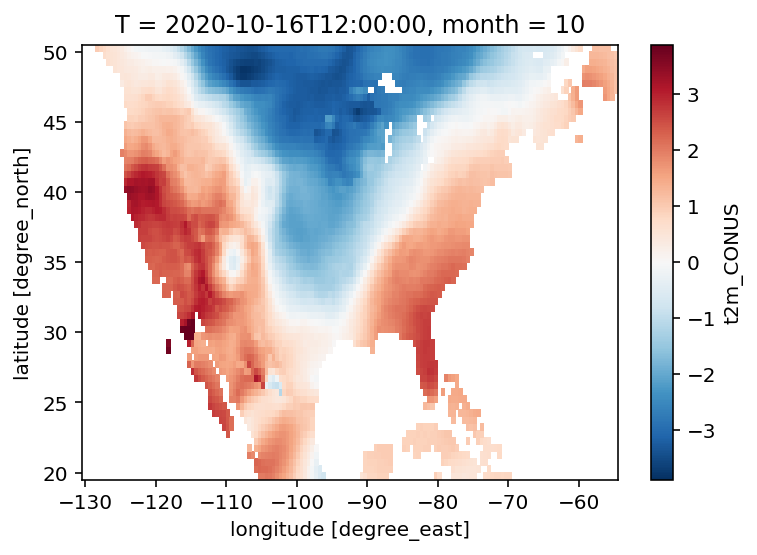

In [153]:
# read and plot last value
t2m_url="http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.t2m_CONUS/dods"
t2m_ds = xr.open_dataset(t2m_url)
t2m = t2m_ds.t2m_CONUS
#t2m.load()
t2ma = t2m.groupby('T.month') - t2m.sel(T = slice('1981', '2010')).groupby('T.month').mean('T')

t2ma = t2ma.sel(T = slice('1948-01', '2020-10'))
print(t2ma.shape)
t2ma.isel(T=-1).plot();